In [2]:
#in this code, we modify the NN input at the begining of each new step block os period=Tbatch
import os
%matplotlib inline
os.environ['TF_CPP_MIN_LOG_LEVEL']="2"
import numpy as np # linear algebra
from pyvis.network import Network
import networkx as nx
from numpy import save
from numpy import load
import random
from numpy import newaxis
from numpy import array
from numpy import array
import torch
from torch.optim import lr_scheduler
torch.manual_seed(0)
from torch import nn
torch.pi = torch.acos(torch.zeros(1)).item() * 2 # which is 3.1415927410125732  
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
import array
from sklearn.metrics import confusion_matrix 
plt.style.use('seaborn-whitegrid')
print ('import completed')

import completed


In [3]:
torch.autograd.set_detect_anomaly(True)

#initializing the power time and distance
global N
global t
global Time_res
global Tnode
global TimeOfFlight_Matrix
global RSSI_Matrix
N=16
TT=2800 #NUMBER OF SLOTS IN THE TDMA FRAME 
Tbatch=10 #This denotes the number of iterations within which we obtain data
t=torch.zeros((N,TT))
Tx_powers=1.995*np.ones((N,1), dtype=int)
N_height=1.5
AttExp = 4             # Attenuation Exponent (4 = 2-RAY MODEL)
AttConst = 1000**2     # Attenuation coefficient (e.g., Aeff)
X_max=10
Y_max=10
Time_res=torch.tensor(1/200)
p_0=3.9811 * (10**(-15)) # Threshold power
C = 3*(10**8);           # speed of light in meters/second
Eps0=1

##### NEURAL NETWORKS

In [3]:
# #SETTING THE INDIVIDUAL Ti FORA LL NODES

# a=1/(10**(torch.FloatTensor(16, 1).uniform_(4, 6)))
# b=torch.FloatTensor(N,1).uniform_(-1,1)
# for ind in range(N):
#     if b[ind]<0:
#         b[ind]=-1
#     else:
#         b[ind]=1
# for ind in range(N):
#     Tnode[ind]=Time_res*(1+b[ind]*a[ind])
# save('myNodePeriod.npy', Tnode) #save as numpy


In [4]:
#lOADING PARAMETERS AS TENSORS

location_X=torch.tensor(load('mycoordinateX.npy')) #X Co-ordinates of all the nodes

location_Y=torch.tensor(load('mycoordinateY.npy')) #Y Co-ordinates of al the nodes

#Allocating the different node distances randomly
Distance_matrix=torch.zeros((N,N))
for i in range(N):
    for j in range(i+1, N):
        Distance_matrix[i,j]=1000*torch.sqrt(torch.square(location_X[j]-location_X[i])+torch.square(location_Y[j]-location_Y[i]))
        Distance_matrix[j,i]=Distance_matrix[i,j]

#Evaluating the propagation delay across different node distances 
TimeOfFlight_Matrix = torch.zeros((N,N))

for ii in range (N):
    for jj in range (N):
        TimeOfFlight_Matrix[ii,jj]=Distance_matrix[ii,jj]/C
        TimeOfFlight_Matrix[jj,ii]=TimeOfFlight_Matrix[ii,jj]

#Generating power RSSI matrix, i.e. Pr
#Row index = receiver, Column index = transmitter
RSSI_Matrix = torch.zeros((N,N))
for i in range(N):
    for j in range(N):
        if i != j :     # If ii=jj the RSSI is infinite
            RSSI_Matrix[i,j] = (Tx_powers[j]*N_height**2)/(Distance_matrix[i,j]**AttExp)
            if RSSI_Matrix[i,j]<p_0:
                RSSI_Matrix[i,j]=0
        elif i == j:
            RSSI_Matrix[i,j] = 0

Tnode=torch.tensor(load('myNodePeriod.npy'))

t[:,0]=torch.tensor(load('myinitial_time.npy'))

Text(0, 0.5, 'y-coordinate')

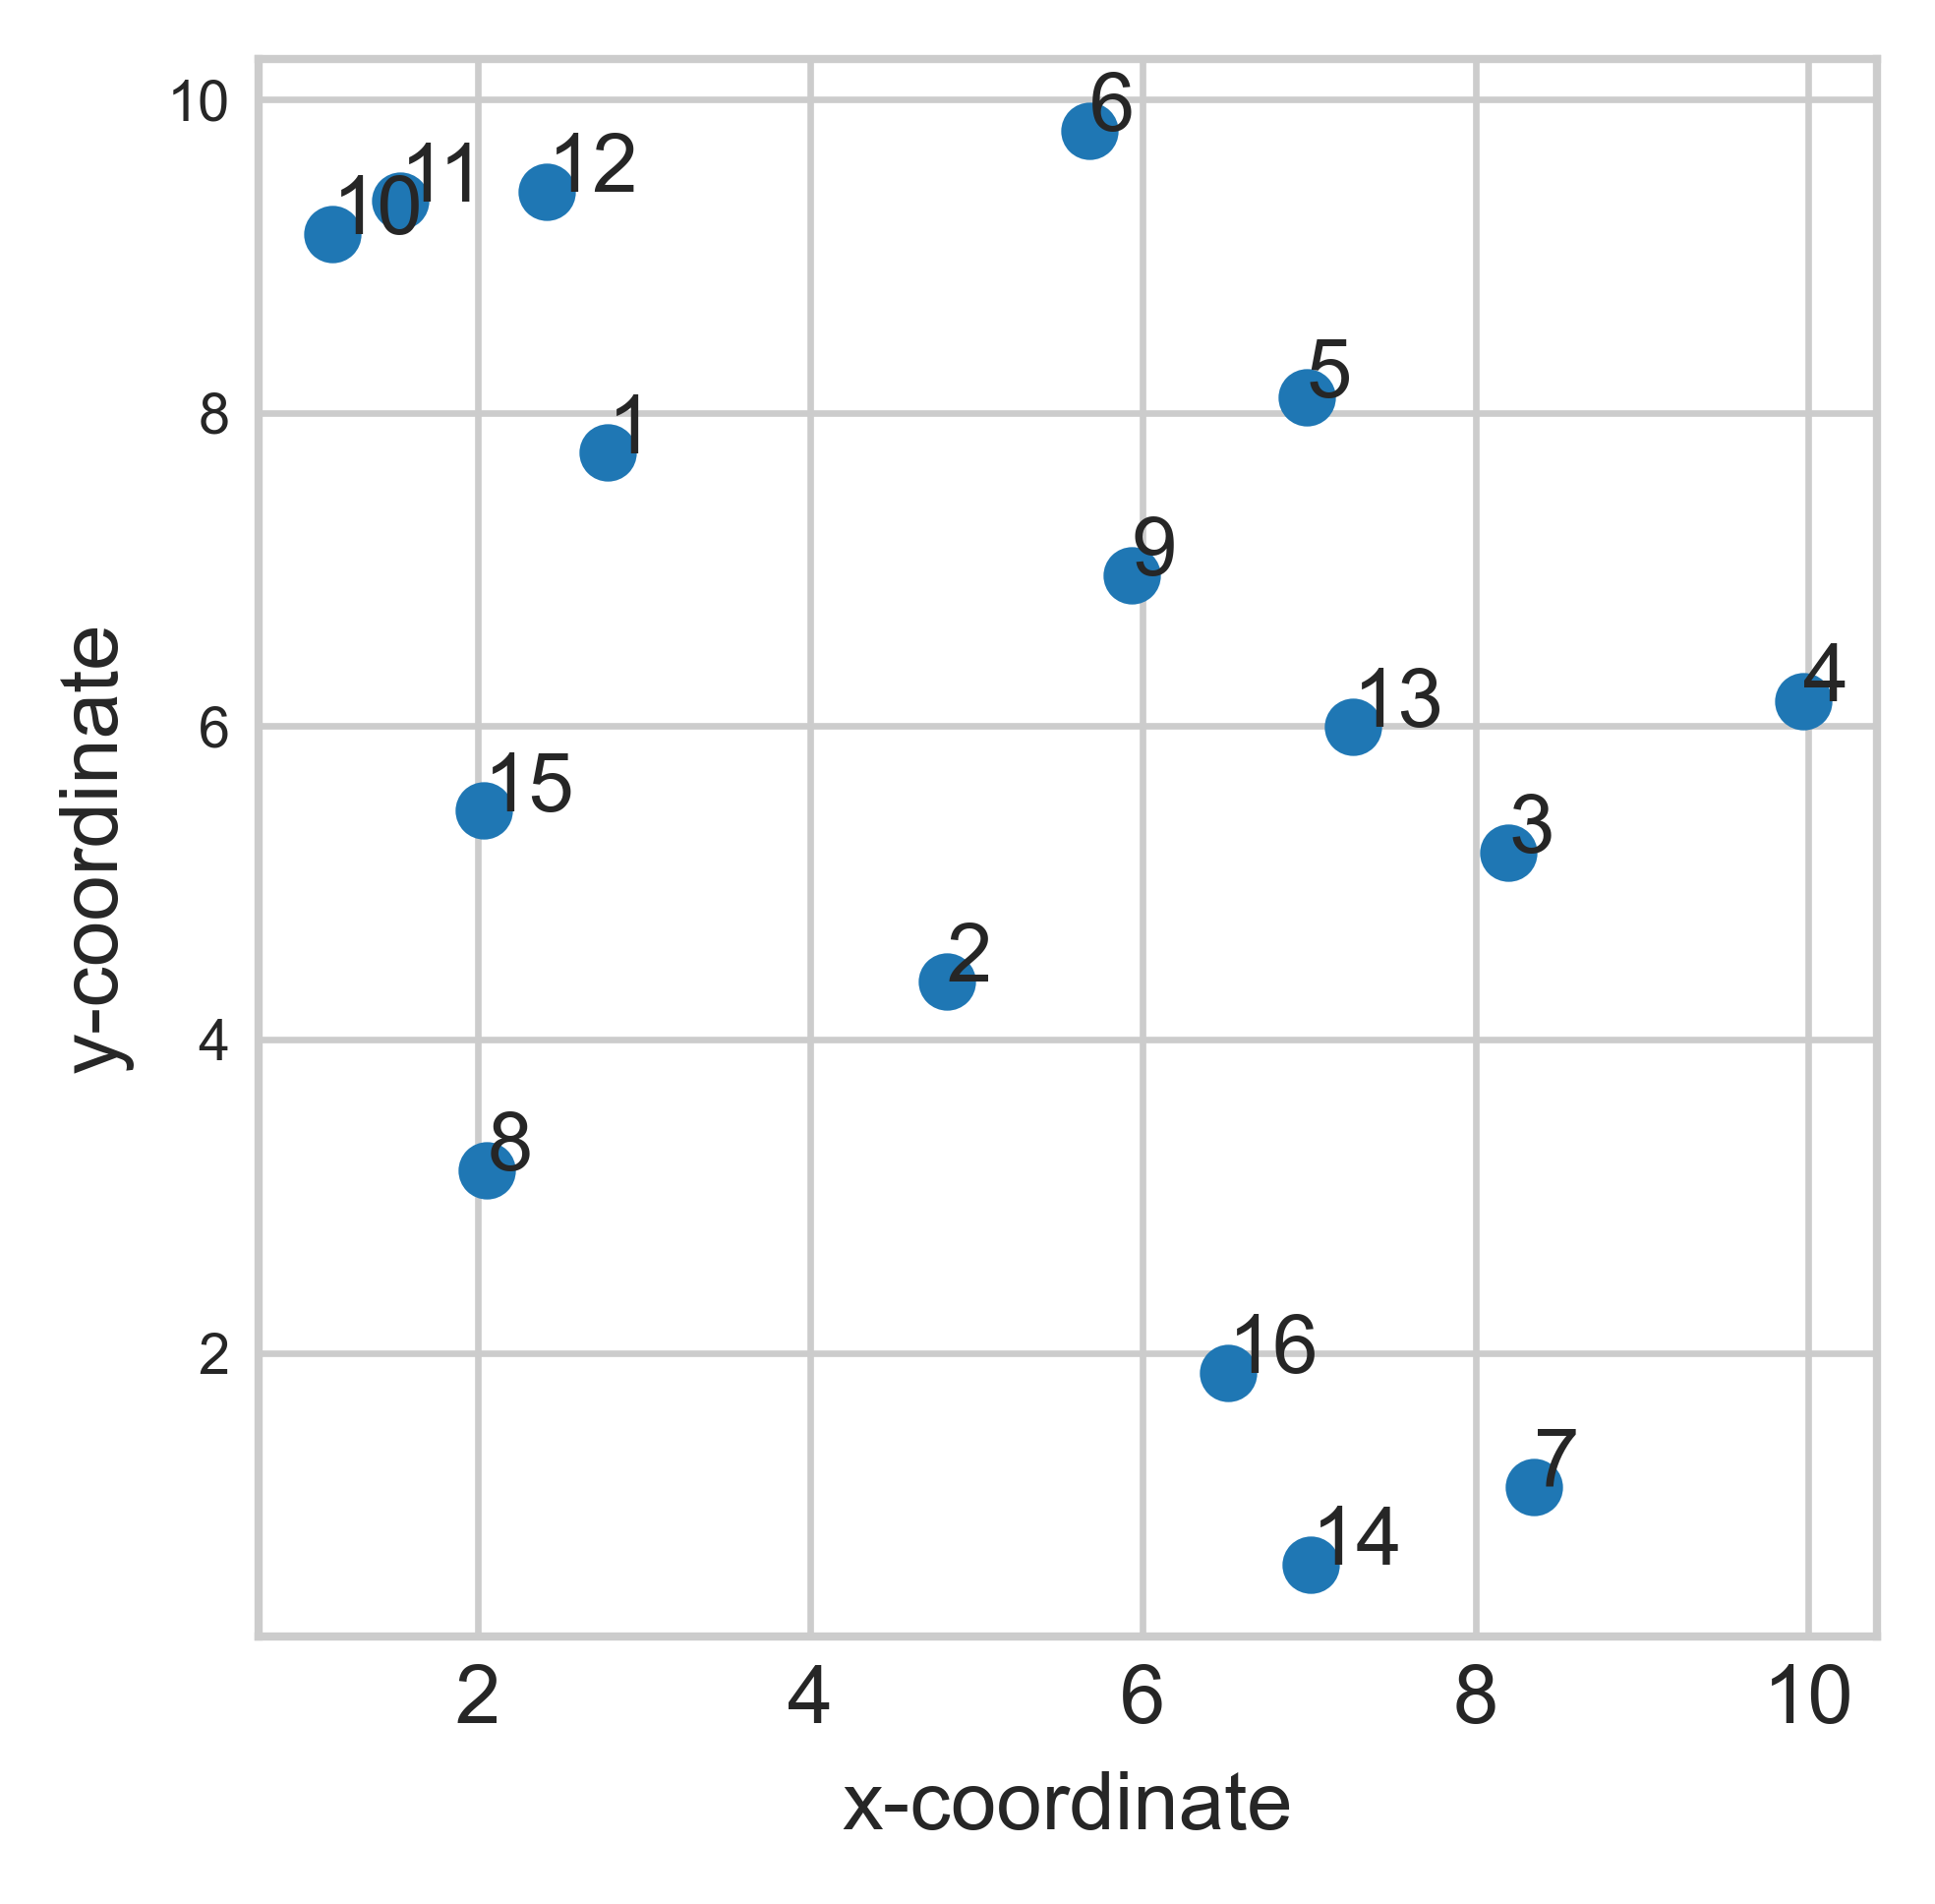

In [5]:
# NETWORK TOPOLOGY

plt.rc('ytick', labelsize='x-small')
fig=plt.figure(dpi=600)
fig.set_size_inches(3.54,3.54)
plt.scatter(location_X, location_Y, label='WSN Layout', marker='o')
for index in range(N):
    plt.text(x=location_X[index],y=location_Y[index], s= index+1)
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')

In [8]:
#MAKING THE CONNECTIVITY GRAPH       
CONNECTION=np.zeros((N,N))

for i in range(N):
    for j in range(N):
        if RSSI_Matrix[i,j] == 0:     # If ii=jj the RSSI is infinite
            CONNECTION[i,j]=0
        else:
            CONNECTION[i,j] = 1

K=nx.from_numpy_matrix(CONNECTION) #creates the graph from connection matrix
mapping=dict(zip(K,range(1,17))) #Reorders the node labels such that it counts from 1-16 instead of 0-15
K=nx.relabel_nodes(K,mapping, copy=False) #applies the new label to the network
nt=Network('400px','400px')
nt.from_nx(K)
nt.show('example.html')

In [9]:
# Get cpu or gpu device for training.
device = "cpu" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))


# Defining the Network model for 16 nodes
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        """this is the neural network 
        it can take a shape of 2*N columns by any rows
        the output layer is 2
        """
        #NN FOR NODE 0
        self.m0 = nn.Sequential(
            nn.Linear(2*(N-1),30),
            nn.Sigmoid(),
            nn.Linear(30,30),
            nn.Sigmoid(),
            nn.Linear(30,N-1),
            nn.Softmax(dim=1),
        )
        #NN FOR NODE 1
        
        self.m1 = nn.Sequential(
            nn.Linear(2*(N-1),30),
            nn.Sigmoid(),
            nn.Linear(30,30),
            nn.Sigmoid(),
            nn.Linear(30,N-1),
            nn.Softmax(dim=1),
        )
        
        #NN FOR NODE 2
        
        self.m2 = nn.Sequential(
            nn.Linear(2*(N-1),30),
            nn.Sigmoid(),
            nn.Linear(30,30),
            nn.Sigmoid(),
            nn.Linear(30,N-1),
            nn.Softmax(dim=1),
        )
        
        #NN FOR NODE 3
        self.m3 = nn.Sequential(
            nn.Linear(2*(N-1),30),
            nn.Sigmoid(),
            nn.Linear(30,30),
            nn.Sigmoid(),
            nn.Linear(30,N-1),
            nn.Softmax(dim=1),
        )
 
        #NN FOR NODE 4
        self.m4 = nn.Sequential(
            nn.Linear(2*(N-1),30),
            nn.Sigmoid(),
            nn.Linear(30,30),
            nn.Sigmoid(),
            nn.Linear(30,N-1),
            nn.Softmax(dim=1),
        )        
        
        #NN FOR NODE 5
        self.m5 = nn.Sequential(
            nn.Linear(2*(N-1),30),
            nn.Sigmoid(),
            nn.Linear(30,30),
            nn.Sigmoid(),
            nn.Linear(30,N-1),
            nn.Softmax(dim=1),
        )
        
        #NN FOR NODE 6
        self.m6 = nn.Sequential(
            nn.Linear(2*(N-1),30),
            nn.Sigmoid(),
            nn.Linear(30,30),
            nn.Sigmoid(),
            nn.Linear(30,N-1),
            nn.Softmax(dim=1),
        )        
        
        #NN FOR NODE 7
        self.m7 = nn.Sequential(
            nn.Linear(2*(N-1),30),
            nn.Sigmoid(),
            nn.Linear(30,30),
            nn.Sigmoid(),
            nn.Linear(30,N-1),
            nn.Softmax(dim=1),
        )        
        
        #NN FOR NODE 8
        self.m8 = nn.Sequential(
            nn.Linear(2*(N-1),30),
            nn.Sigmoid(),
            nn.Linear(30,30),
            nn.Sigmoid(),
            nn.Linear(30,N-1),
            nn.Softmax(dim=1),
        )        
        
        #NN FOR NODE 9
        self.m9 = nn.Sequential(
            nn.Linear(2*(N-1),30),
            nn.Sigmoid(),
            nn.Linear(30,30),
            nn.Sigmoid(),
            nn.Linear(30,N-1),
            nn.Softmax(dim=1),
        )        
        
        #NN FOR NODE 10
        self.m10 = nn.Sequential(
            nn.Linear(2*(N-1),30),
            nn.Sigmoid(),
            nn.Linear(30,30),
            nn.Sigmoid(),
            nn.Linear(30,N-1),
            nn.Softmax(dim=1),
        )       
        
        #NN FOR NODE 11
        self.m11 = nn.Sequential(
            nn.Linear(2*(N-1),30),
            nn.Sigmoid(),
            nn.Linear(30,30),
            nn.Sigmoid(),
            nn.Linear(30,N-1),
            nn.Softmax(dim=1),
        )        
        
        #NN FOR NODE 12
        self.m12 = nn.Sequential(
            nn.Linear(2*(N-1),30),
            nn.Sigmoid(),
            nn.Linear(30,30),
            nn.Sigmoid(),
            nn.Linear(30,N-1),
            nn.Softmax(dim=1),
        )        
        
        #NN FOR NODE 13
        self.m13 = nn.Sequential(
            nn.Linear(2*(N-1),30),
            nn.Sigmoid(),
            nn.Linear(30,30),
            nn.Sigmoid(),
            nn.Linear(30,N-1),
            nn.Softmax(dim=1),
        )        
        
        #NN FOR NODE 14
        self.m14 = nn.Sequential(
            nn.Linear(2*(N-1),30),
            nn.Sigmoid(),
            nn.Linear(30,30),
            nn.Sigmoid(),
            nn.Linear(30,N-1),
            nn.Softmax(dim=1),
        )       
        
        #NN FOR NODE 15
        self.m15 = nn.Sequential(
            nn.Linear(2*(N-1),30),
            nn.Sigmoid(),
            nn.Linear(30,30),
            nn.Sigmoid(),
            nn.Linear(30,N-1),
            nn.Softmax(dim=1),
        )
 
    #FORWARD PASS FOR NODE 0
    def T0_forward(self, x):
        #x is input data that you want to pass into the neural network
        # self.network_output is network output
        self.network_output0 = self.m0(x)
        return self.network_output0
    
    #FORWARD PASS FOR NODE 1
    def T1_forward(self, x):
        #x is input data that you want to pass into the neural network
        # self.network_output is network output
        self.network_output1 = self.m1(x)
        return self.network_output1
    
    #FORWARD PASS FOR NODE 2
    def T2_forward(self, x):
        #x is input data that you want to pass into the neural network
        # self.network_output is network output
        self.network_output2 = self.m2(x)
        return self.network_output2

    #FORWARD PASS FOR NODE 3
    def T3_forward(self, x):
        #x is input data that you want to pass into the neural network
        # self.network_output is network output
        self.network_output3 = self.m3(x)
        return self.network_output3
    
    #FORWARD PASS FOR NODE 4
    def T4_forward(self, x):
        #x is input data that you want to pass into the neural network
        # self.network_output is network output
        self.network_output4 = self.m4(x)
        return self.network_output4

    #FORWARD PASS FOR NODE 5
    def T5_forward(self, x):
        #x is input data that you want to pass into the neural network
        # self.network_output is network output
        self.network_output5 = self.m5(x)
        return self.network_output5
    
    #FORWARD PASS FOR NODE 6
    def T6_forward(self, x):
        #x is input data that you want to pass into the neural network
        # self.network_output is network output
        self.network_output6 = self.m6(x)
        return self.network_output6
    
    #FORWARD PASS FOR NODE 7
    def T7_forward(self, x):
        #x is input data that you want to pass into the neural network
        # self.network_output is network output
        self.network_output7 = self.m7(x)
        return self.network_output7
    
    #FORWARD PASS FOR NODE 8
    def T8_forward(self, x):
        #x is input data that you want to pass into the neural network
        # self.network_output is network output
        self.network_output8 = self.m8(x)
        return self.network_output8
    
    #FORWARD PASS FOR NODE 9
    def T9_forward(self, x):
        #x is input data that you want to pass into the neural network
        # self.network_output is network output
        self.network_output9 = self.m9(x)
        return self.network_output9
    
    #FORWARD PASS FOR NODE 10
    def T10_forward(self, x):
        #x is input data that you want to pass into the neural network
        # self.network_output is network output
        self.network_output10 = self.m10(x)
        return self.network_output10
    
    #FORWARD PASS FOR NODE 11
    def T11_forward(self, x):
        #x is input data that you want to pass into the neural network
        # self.network_output is network output
        self.network_output11 = self.m11(x)
        return self.network_output11
    
    #FORWARD PASS FOR NODE 12
    def T12_forward(self, x):
        #x is input data that you want to pass into the neural network
        # self.network_output is network output
        self.network_output12 = self.m12(x)
        return self.network_output12
    
    #FORWARD PASS FOR NODE 13
    def T13_forward(self, x):
        #x is input data that you want to pass into the neural network
        # self.network_output is network output
        self.network_output13 = self.m13(x)
        return self.network_output13
    
    #FORWARD PASS FOR NODE 14
    def T14_forward(self, x):
        #x is input data that you want to pass into the neural network
        # self.network_output is network output
        self.network_output14 = self.m14(x)
        return self.network_output14
    
    #FORWARD PASS FOR NODE 15
    def T15_forward(self, x):
        #x is input data that you want to pass into the neural network
        # self.network_output is network output
        self.network_output15 = self.m15(x)
        return self.network_output15
    
        
    
    
model = NeuralNetwork().to(device)

Using cpu device


In [5]:
#DEFINING THE LOSS FUNCTION FOR EACH NODE'S NN
def lossfn(tvec,Nodetime):
    #tvec is the vector of received time indices from all the nodes
    # Nodetime is the instantaneous time at considered node
    sumerror=0
    for index in range(N-1):
        if (tvec[0,index]!=0):
            sumerror=sumerror+(tvec[0,index]-Nodetime)**2
        else:
            sumerror=sumerror
    return sumerror

In [6]:
#DEFINING THE LOSS FUNCTION FOR EACH NODE'S NN
def lossfn1(tvec,Nodetime):
    #tvec is the vector of received time indices from all the nodes
    # Nodetime is the instantaneous time at considered node
    sumerror=0
    for index in range(N-1):
        if (tvec[index]!=0):
            sumerror=sumerror+(tvec[index]-Nodetime)**2
        else:
            sumerror=sumerror
    return sumerror

In [10]:
#DEFINING THE FUNCTION TO OBTAIN WEIGHT FOR EACH NODE'S NN
def Dnn_Out(DNN_INPUT):
    #DNN_INPUT IS AN N X 2(N-1) MATRIX OF INPUT DATA
    Weight={}
    Weight[0] = model.T0_forward(DNN_INPUT[0:1,:]).reshape(1, (N-1))
    Weight[1] = model.T1_forward(DNN_INPUT[1:2,:]).reshape(1, (N-1))
    Weight[2] = model.T2_forward(DNN_INPUT[2:3,:]).reshape(1, (N-1))
    Weight[3] = model.T3_forward(DNN_INPUT[3:4,:]).reshape(1, (N-1))
    Weight[4] = model.T4_forward(DNN_INPUT[4:5,:]).reshape(1, (N-1))
    Weight[5] = model.T5_forward(DNN_INPUT[5:6,:]).reshape(1, (N-1))
    Weight[6] = model.T6_forward(DNN_INPUT[6:7,:]).reshape(1, (N-1))
    Weight[7] = model.T7_forward(DNN_INPUT[7:8,:]).reshape(1, (N-1))
    Weight[8] = model.T8_forward(DNN_INPUT[8:9,:]).reshape(1, (N-1))
    Weight[9] = model.T9_forward(DNN_INPUT[9:10,:]).reshape(1, (N-1))
    Weight[10] = model.T10_forward(DNN_INPUT[10:11,:]).reshape(1, (N-1))
    Weight[11] = model.T11_forward(DNN_INPUT[11:12,:]).reshape(1, (N-1))
    Weight[12] = model.T12_forward(DNN_INPUT[12:13,:]).reshape(1, (N-1))
    Weight[13] = model.T13_forward(DNN_INPUT[13:14,:]).reshape(1, (N-1))
    Weight[14] = model.T14_forward(DNN_INPUT[14:15,:]).reshape(1, (N-1))
    Weight[15] = model.T15_forward(DNN_INPUT[15:16,:]).reshape(1, (N-1))
    
    return Weight

In [10]:
#CREATING DATA OVER THE TIME INTERVAL OF Tbatch USING FORWARD PASS
t_new = torch.zeros(N,N)
Sys_Data= torch.zeros(TT,N,2*(N-1))
NN_INPUT=torch.zeros(N,2*(N-1))
Node=torch.zeros(1,2*(N-1))
NN_weight=torch.zeros(N,(N-1))
diff=torch.zeros(N,N-1)
prod=torch.zeros(1,N)

for i in range(Tbatch):
    #UPDATING THE TIME OF ARRIVAL OF PULSE AT THE RESPECTIVE NODES (t_ij)
    for ii in range(N):
        for jj in range(N):
            t_new[ii,jj]=t[ii,i].item() + TimeOfFlight_Matrix[ii,jj].item()
            if (RSSI_Matrix[ii,jj]==0 and ii!=jj):
                t_new[ii,jj]=0
    
    for b in range(N):
        Node=torch.cat([t_new[0:b,b],t_new[b+1:,b],RSSI_Matrix[b,0:b],RSSI_Matrix[b,b+1:]]).reshape(1, 2*(N-1)) #let the NN TAKE IN JUST THE TIME AND NOT THE DIFFERENCE
        Sys_Data[i,b,:]=Node.clone()
    NN_INPUT=Sys_Data[i,:,:].clone()
    
    for b in range(N):
        for ind in range(N-1):
            if (NN_INPUT[b,ind]!=0):
                NN_INPUT[b,ind]=NN_INPUT[b,ind].item()-t[b,i]
            else:
                NN_INPUT[b,ind]=0
    Weight=Dnn_Out(NN_INPUT)
    for node in range(N):
        NN_weight[node,:]=Weight[node]

    
    for node in range(N):
        diff[node,:]=NN_INPUT[node,0:N-1].reshape(1, (N-1))
        prod[0,node]=torch.sum(diff[node,:]* NN_weight[node,:])
        t[node,i+1]=t[node,i].item() +Tnode[node].item() + Eps0*prod[0,node] #obtains the next clock phase following Eqn.10
    
    

print(Sys_Data)


tensor([[[4.7344e-03, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          1.3461e-13, 0.0000e+00],
         [1.8326e-04, 4.4125e-03, 2.4357e-05,  ..., 1.2952e-14,
          5.6336e-14, 5.4277e-14],
         [0.0000e+00, 4.7328e-03, 1.2913e-05,  ..., 9.2660e-15,
          0.0000e+00, 2.3359e-14],
         ...,
         [0.0000e+00, 4.7356e-03, 4.4165e-03,  ..., 5.4836e-15,
          0.0000e+00, 1.4854e-12],
         [1.7812e-04, 4.7312e-03, 0.0000e+00,  ..., 5.9021e-15,
          0.0000e+00, 4.1533e-15],
         [0.0000e+00, 4.7313e-03, 4.4133e-03,  ..., 1.4549e-14,
          1.4854e-12, 4.1533e-15]],

        [[7.6001e-03, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          1.3461e-13, 0.0000e+00],
         [6.7135e-03, 8.3586e-03, 6.7219e-03,  ..., 1.2952e-14,
          5.6336e-14, 5.4277e-14],
         [0.0000e+00, 7.5985e-03, 6.7104e-03,  ..., 9.2660e-15,
          0.0000e+00, 2.3359e-14],
         ...,
         [0.0000e+00, 7.6013e-03, 8.3627e-03,  ..., 5.4836e-15,
          0.000

In [25]:
# TRAINING THE NNs
timenump=np.zeros((N,TT))
timenump[:,0]=t[:,0].detach().numpy()
Weightdict={}
NN_weight=torch.zeros(N,(N-1),requires_grad=False)
torch.autograd.set_detect_anomaly(True)
optimizer = torch.optim.SGD(model.parameters(), lr=0.4, momentum=0.9)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


epoch_size=500
loss_values=[]

for epoch in range(epoch_size):
#     print(epoch_lossN0.detach().numpy())
    local_lossNN = torch.zeros(1,N)
    epoch_lossNN = torch.zeros(1,N)
    
    NodeInst_time={}
    for i in range(Tbatch-1):
        #Rearrange the received data for each node such that it passes in the phase difference w.r.t. the estimated phase, 
        # and the power
        TrainData=Sys_Data[i,:,:].clone().reshape(N, 2*(N-1))
        #obtain phase difference for non-zero received times.
        for node in range(N):
            for ind in range(N-1):
                if (TrainData[node,ind]!=0):
                    TrainData[node,ind]=TrainData[node,ind].item()-timenump[node,i]
                else:
                    TrainData[node,ind]=0
  
        Weight= Dnn_Out(TrainData)    
        lgtensor=torch.tensor(2+i)
    
        for node in range(N):
            Weightdict[node]=Weight[node]
            diff=TrainData[node,0:N-1].clone() 
            prod=torch.sum(diff* Weightdict[node])
            NodeInst_time[node]=timenump[node,i].item() +Tnode[node].item() + (Eps0*prod)
            timenump[node,i+1]=NodeInst_time[node].detach().numpy() #Saving a detached version of the successive time
            local_lossNN[0,node] = lossfn1(Sys_Data[i+1,node,0:N-1],NodeInst_time[node])
            epoch_lossNN[0,node] = epoch_lossNN[0,node] +torch.log(lgtensor)*local_lossNN[0,node]
    
    newloss = torch.sum(epoch_lossNN[0,0:N].clone())
    loss_values.append(newloss.item())
    optimizer.zero_grad()
    for node in range(N):
        epoch_lossNN[0,node].backward(retain_graph=True)
    
    print(newloss)  
    print(epoch)
    optimizer.step()
    scheduler.step()
    

tensor(8.0067e-05, grad_fn=<SumBackward0>)
0
tensor(8.0066e-05, grad_fn=<SumBackward0>)
1
tensor(8.0065e-05, grad_fn=<SumBackward0>)
2
tensor(8.0064e-05, grad_fn=<SumBackward0>)
3
tensor(8.0062e-05, grad_fn=<SumBackward0>)
4
tensor(8.0060e-05, grad_fn=<SumBackward0>)
5
tensor(8.0058e-05, grad_fn=<SumBackward0>)
6


KeyboardInterrupt: 

Text(0, 0.5, 'Combined Loss $(L_{\\psi})$')

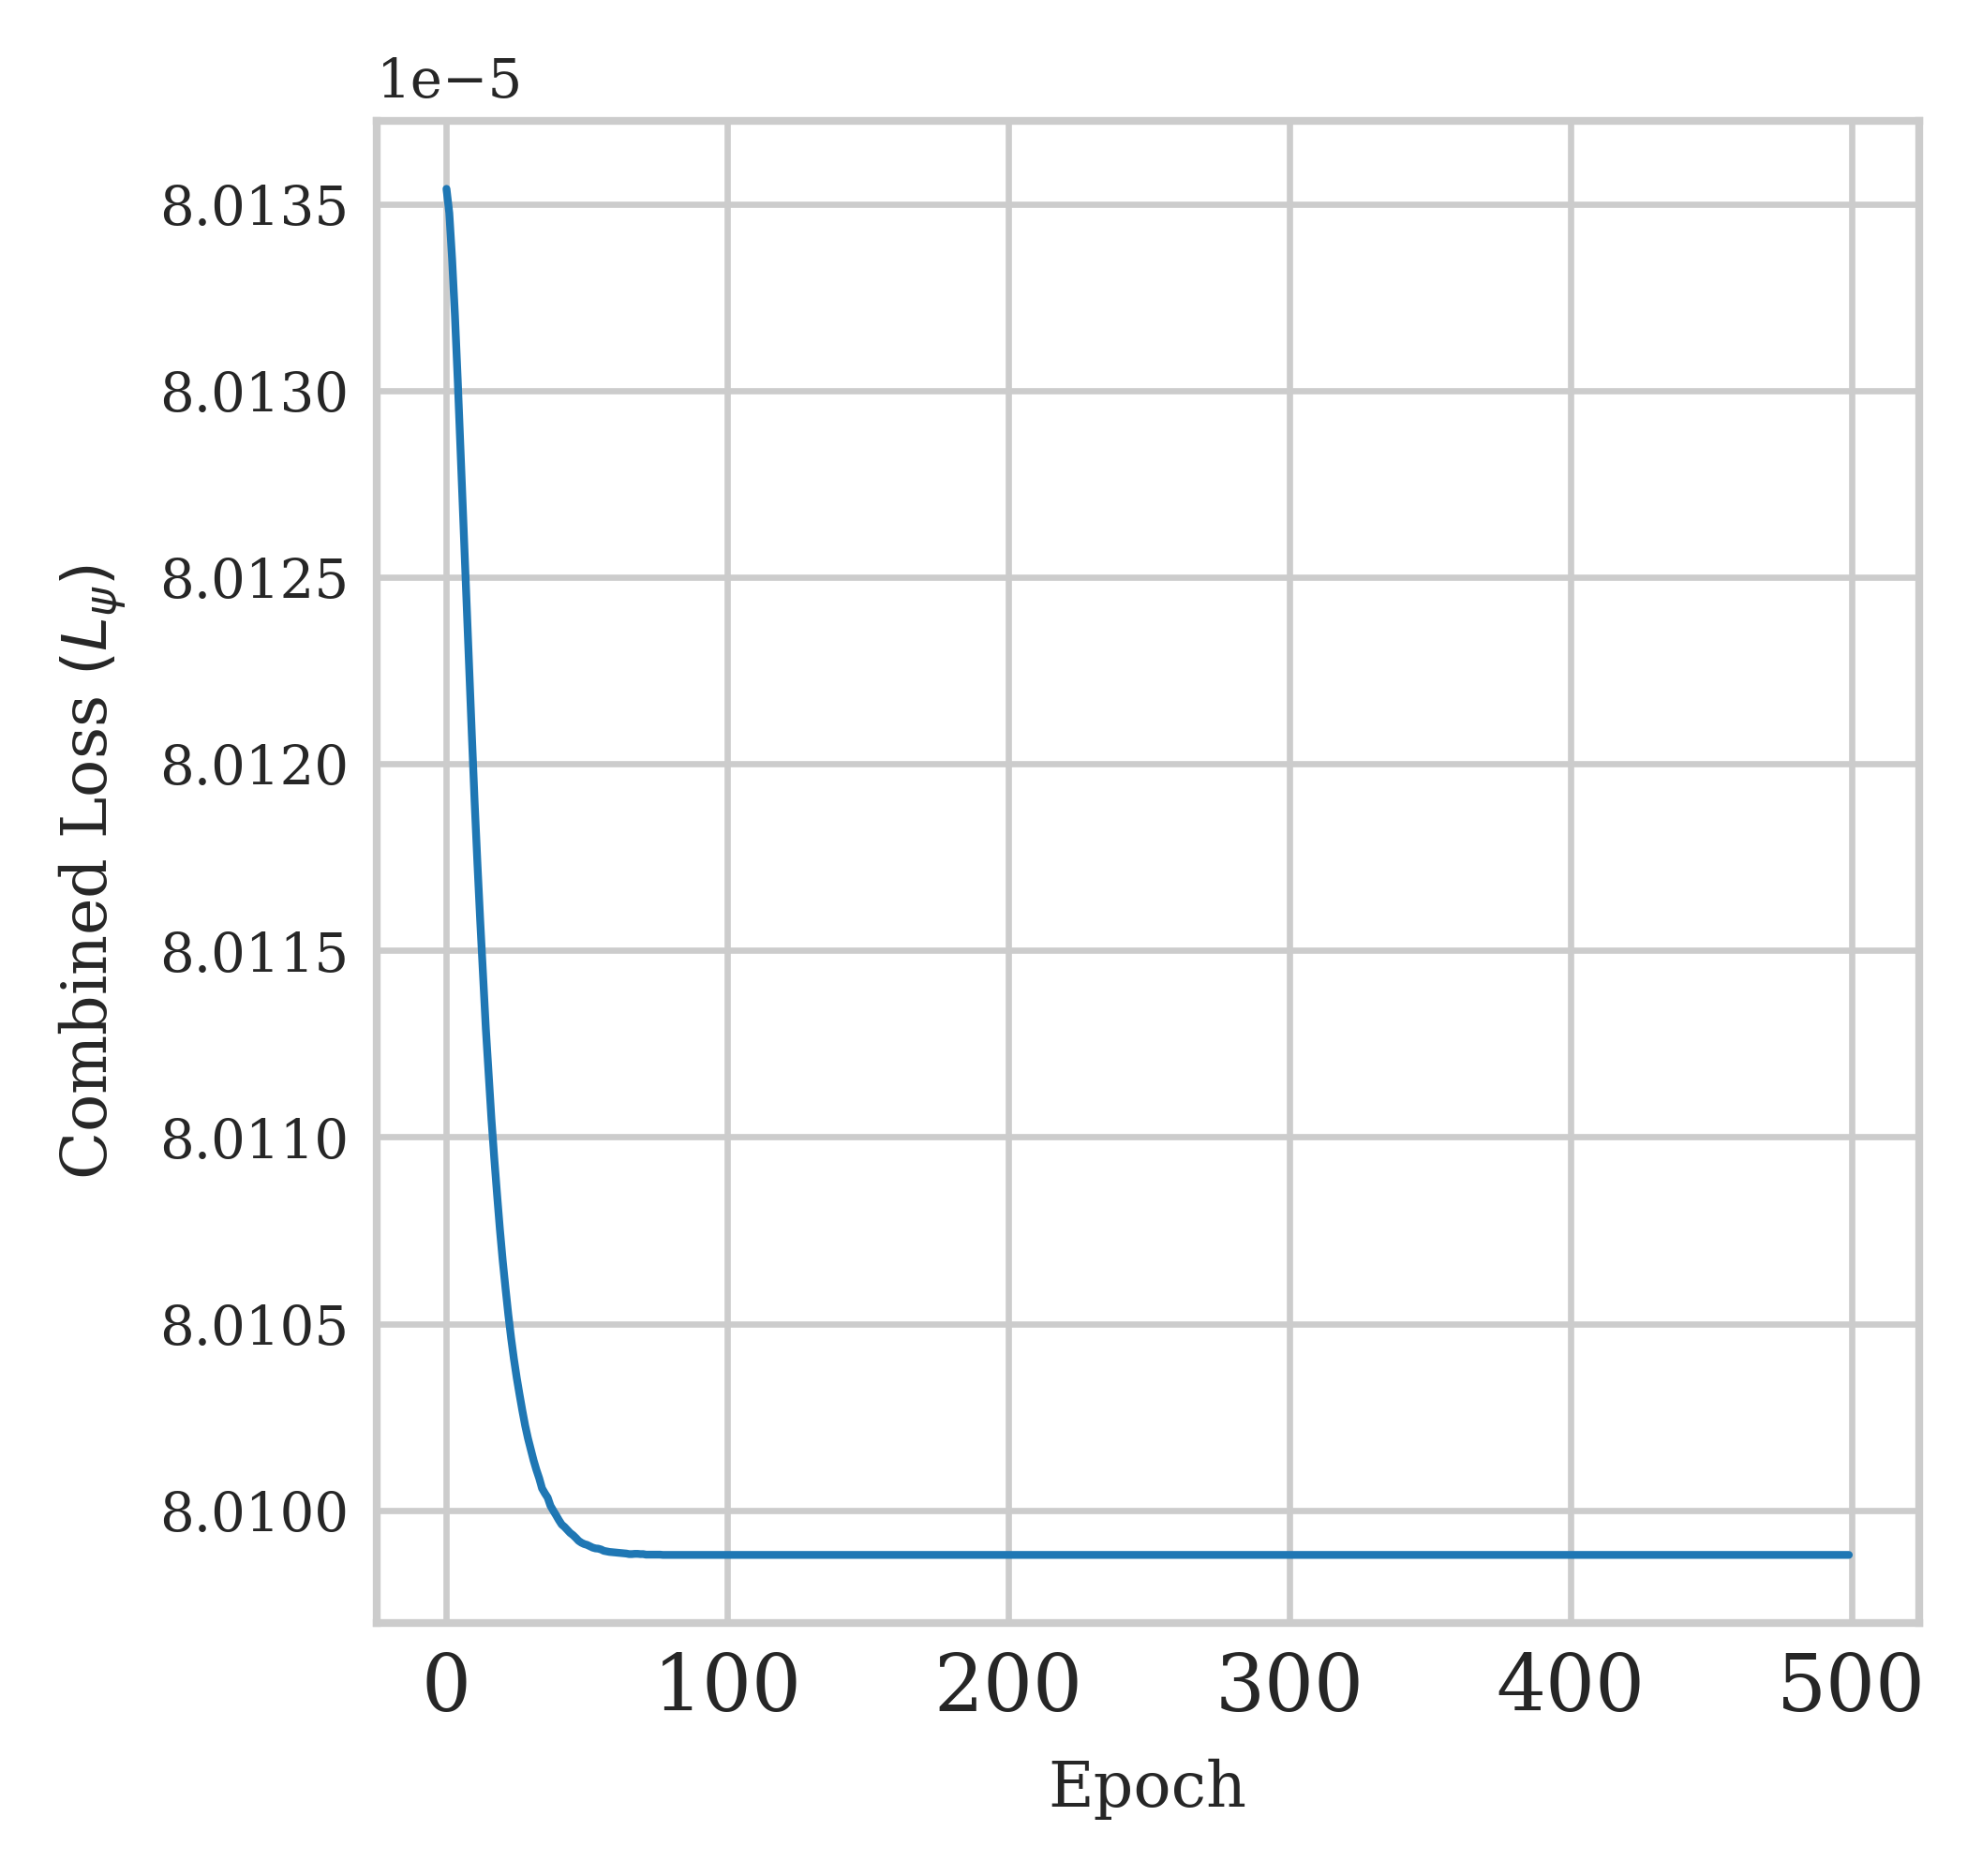

In [20]:
 plt.rc('font', family='serif')
# plt.rc('xtick', labelsize='x-small')
# plt.rc('ytick', labelsize='x-small')
fig=plt.figure(dpi=600)
fig.set_size_inches(3.54,3.54)
plt.plot(loss_values, linewidth=1)
plt.xlabel('Epoch', fontsize=8)
plt.ylabel('Combined Loss $(L_{\psi})$', fontsize=8)

In [82]:
# torch.save(model.state_dict(), 'mymodelweights_only.pth')

##### RUNNING INFERENCE FOR REMAINING TIME WITHOUT RESET

In [3]:
#Testing with the other time indexes
TT=2800

Nodeintest=torch.zeros(N,2*(N-1))
for i in range(Tbatch-1,TT):
    for ii in range(N):
        for jj in range(N):
            with torch.no_grad():
                t_new[ii,jj]=torch.tensor(timenump[ii,i]) + TimeOfFlight_Matrix[ii,jj].clone()
                if (RSSI_Matrix[ii,jj]==0 and ii!=jj):
                    t_new[ii,jj]=0
    
    for b in range(N):
        Node=torch.cat([t_new[0:b,b],t_new[b+1:,b],RSSI_Matrix[b,0:b],RSSI_Matrix[b,b+1:]]) #let the NN TAKE IN JUST THE TIME AND NOT THE DIFFERENCE
        Nodeintest[b,:]=Node
        #Setting the input phase difference to be zero for uncoupled nodes
    for b in range(N): 
        for ind in range(N-1):
            if Nodeintest[b,ind]!=0:
                Nodeintest[b,ind]=Nodeintest[b,ind]-timenump[b,i]
            else:
                Nodeintest[b,ind]=0
               
    if i<=TT-2:
        Weight=Dnn_Out(Nodeintest[:,:])
        for node in range(N):
            NN_weight[node,:]=Weight[node]
            
        
        for node in range(N):
            diff[node,:]=Nodeintest[node,0:N-1].reshape(1, (N-1))
            prod[0,node]=torch.sum(diff[node,:]* NN_weight[node,:])
            timenump[node,i+1]=timenump[node,i] +Tnode[node].item() + Eps0*prod[0,node] 
        
        

NameError: name 'torch' is not defined

In [27]:
timenump=load('clockphase_fixedtrainFixedtest.npy') #save as numpy

Text(0, 0.5, 'Variance of Period')

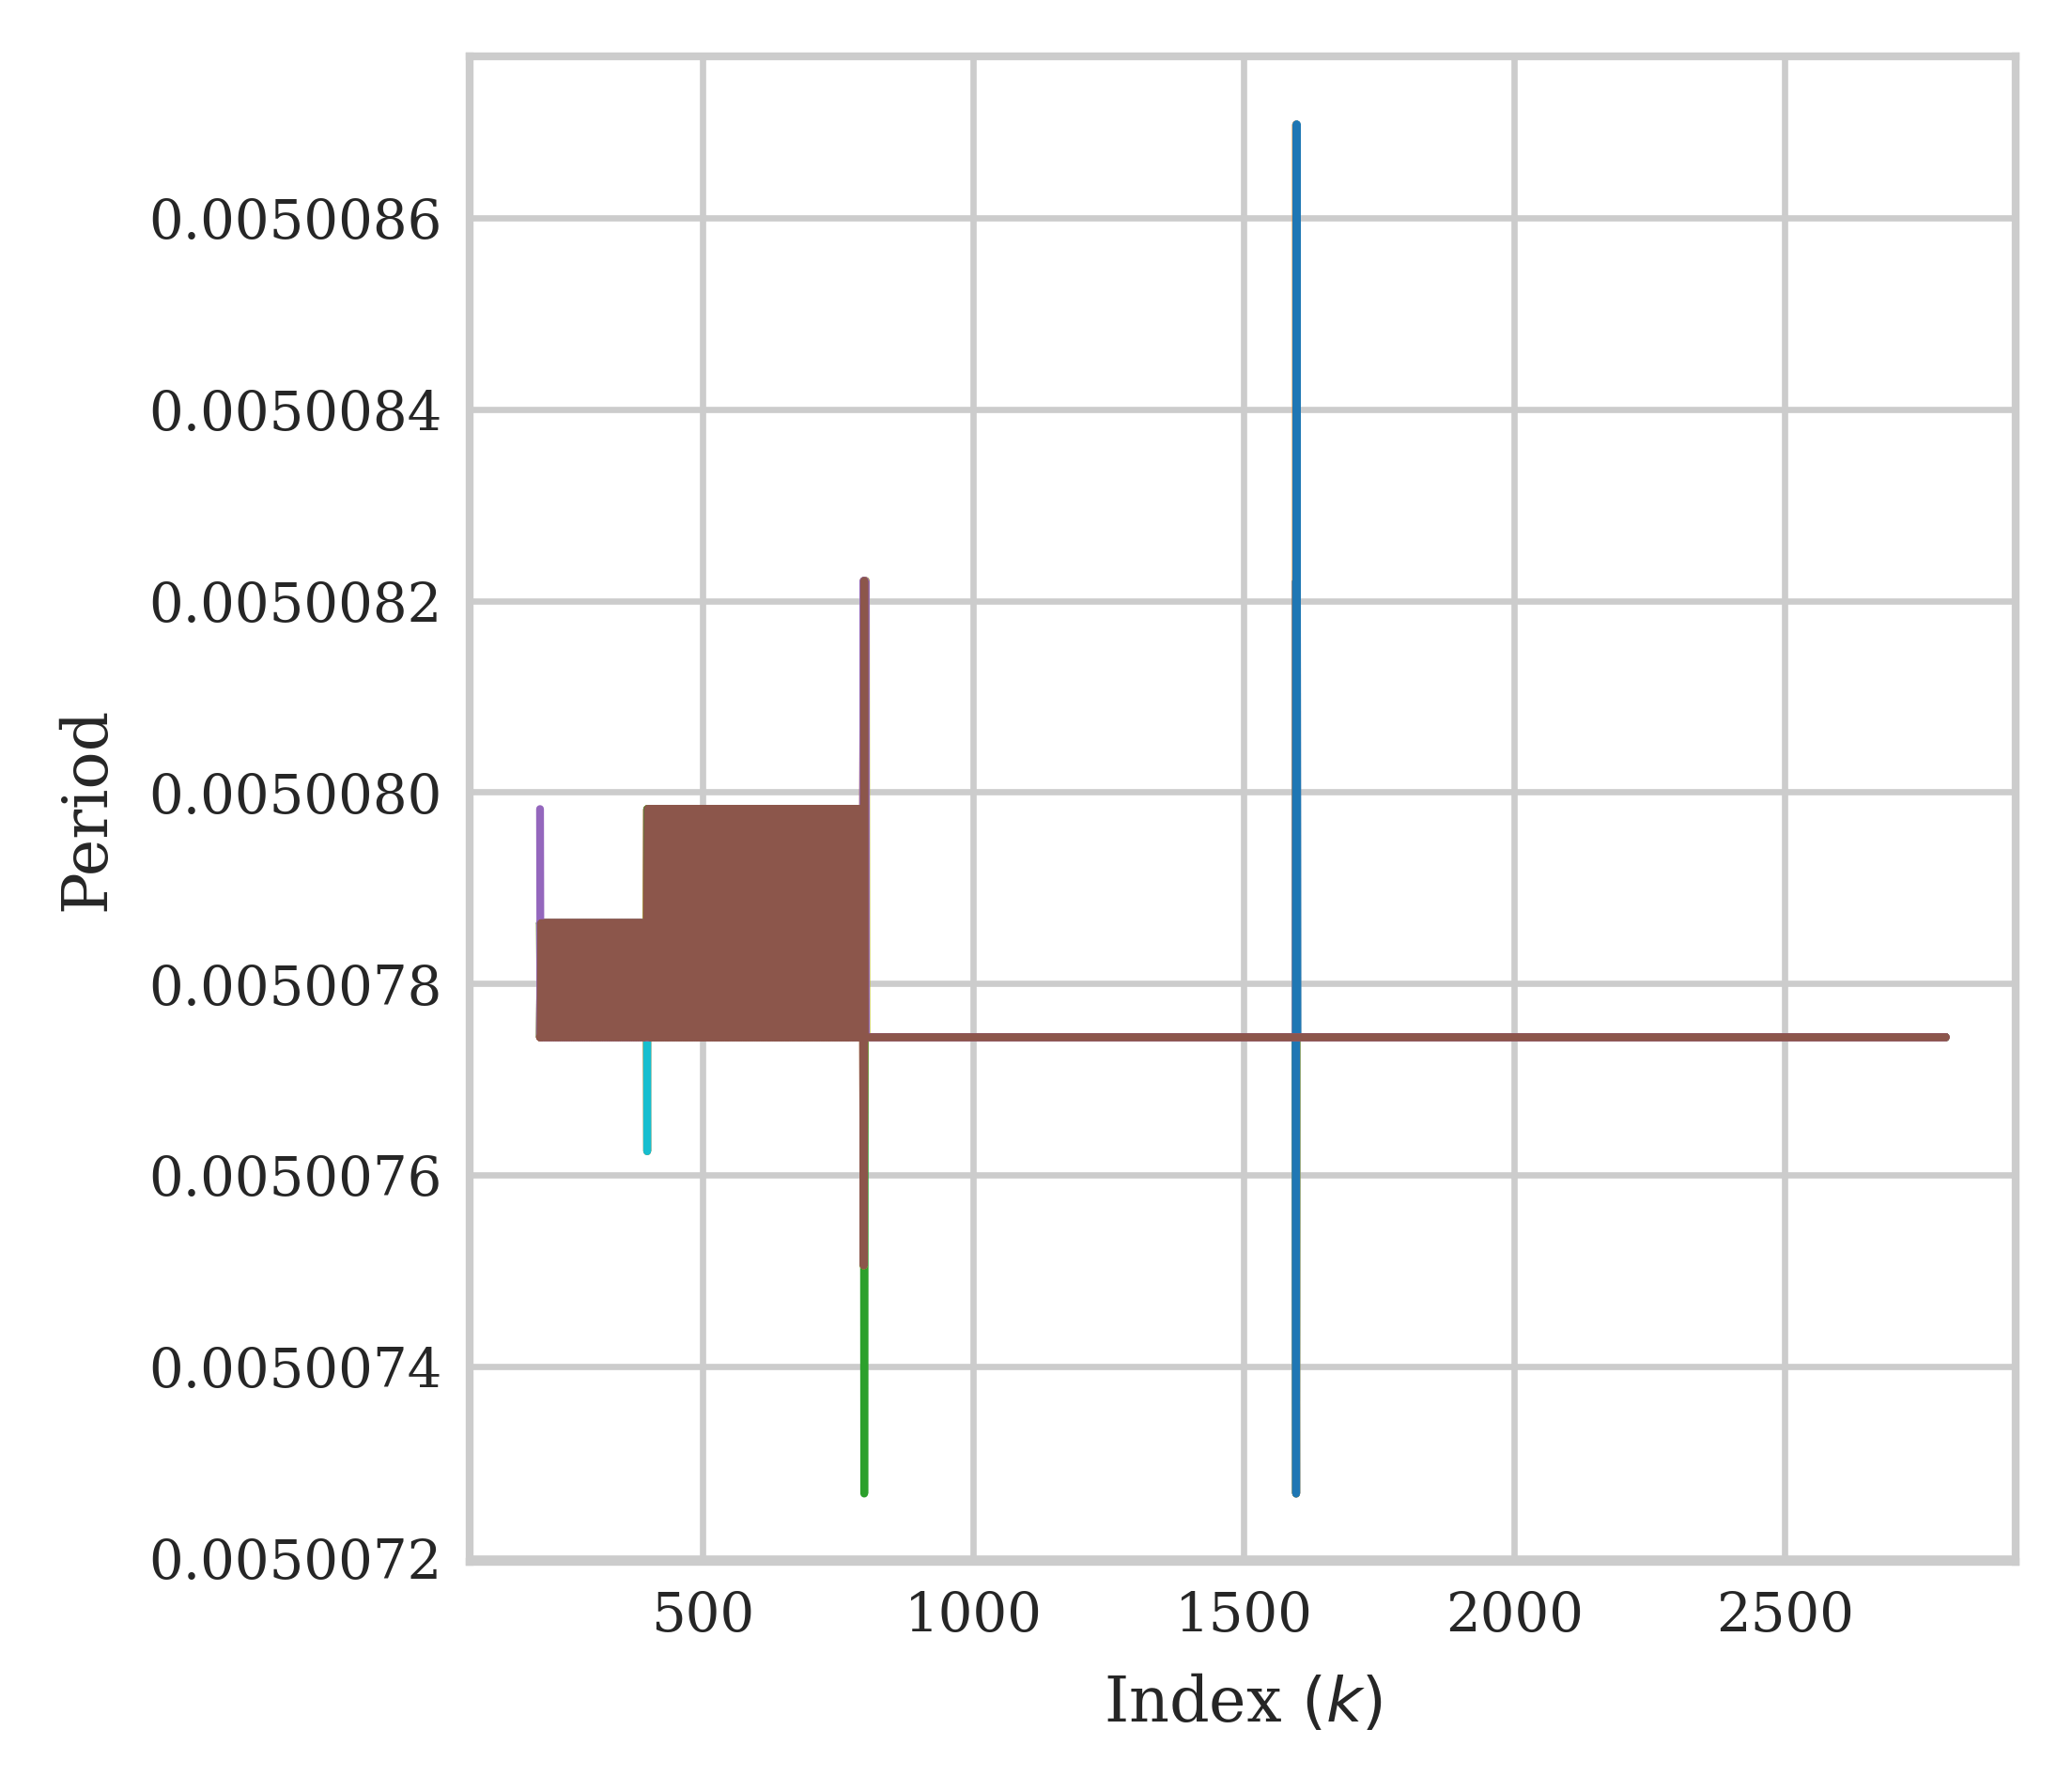

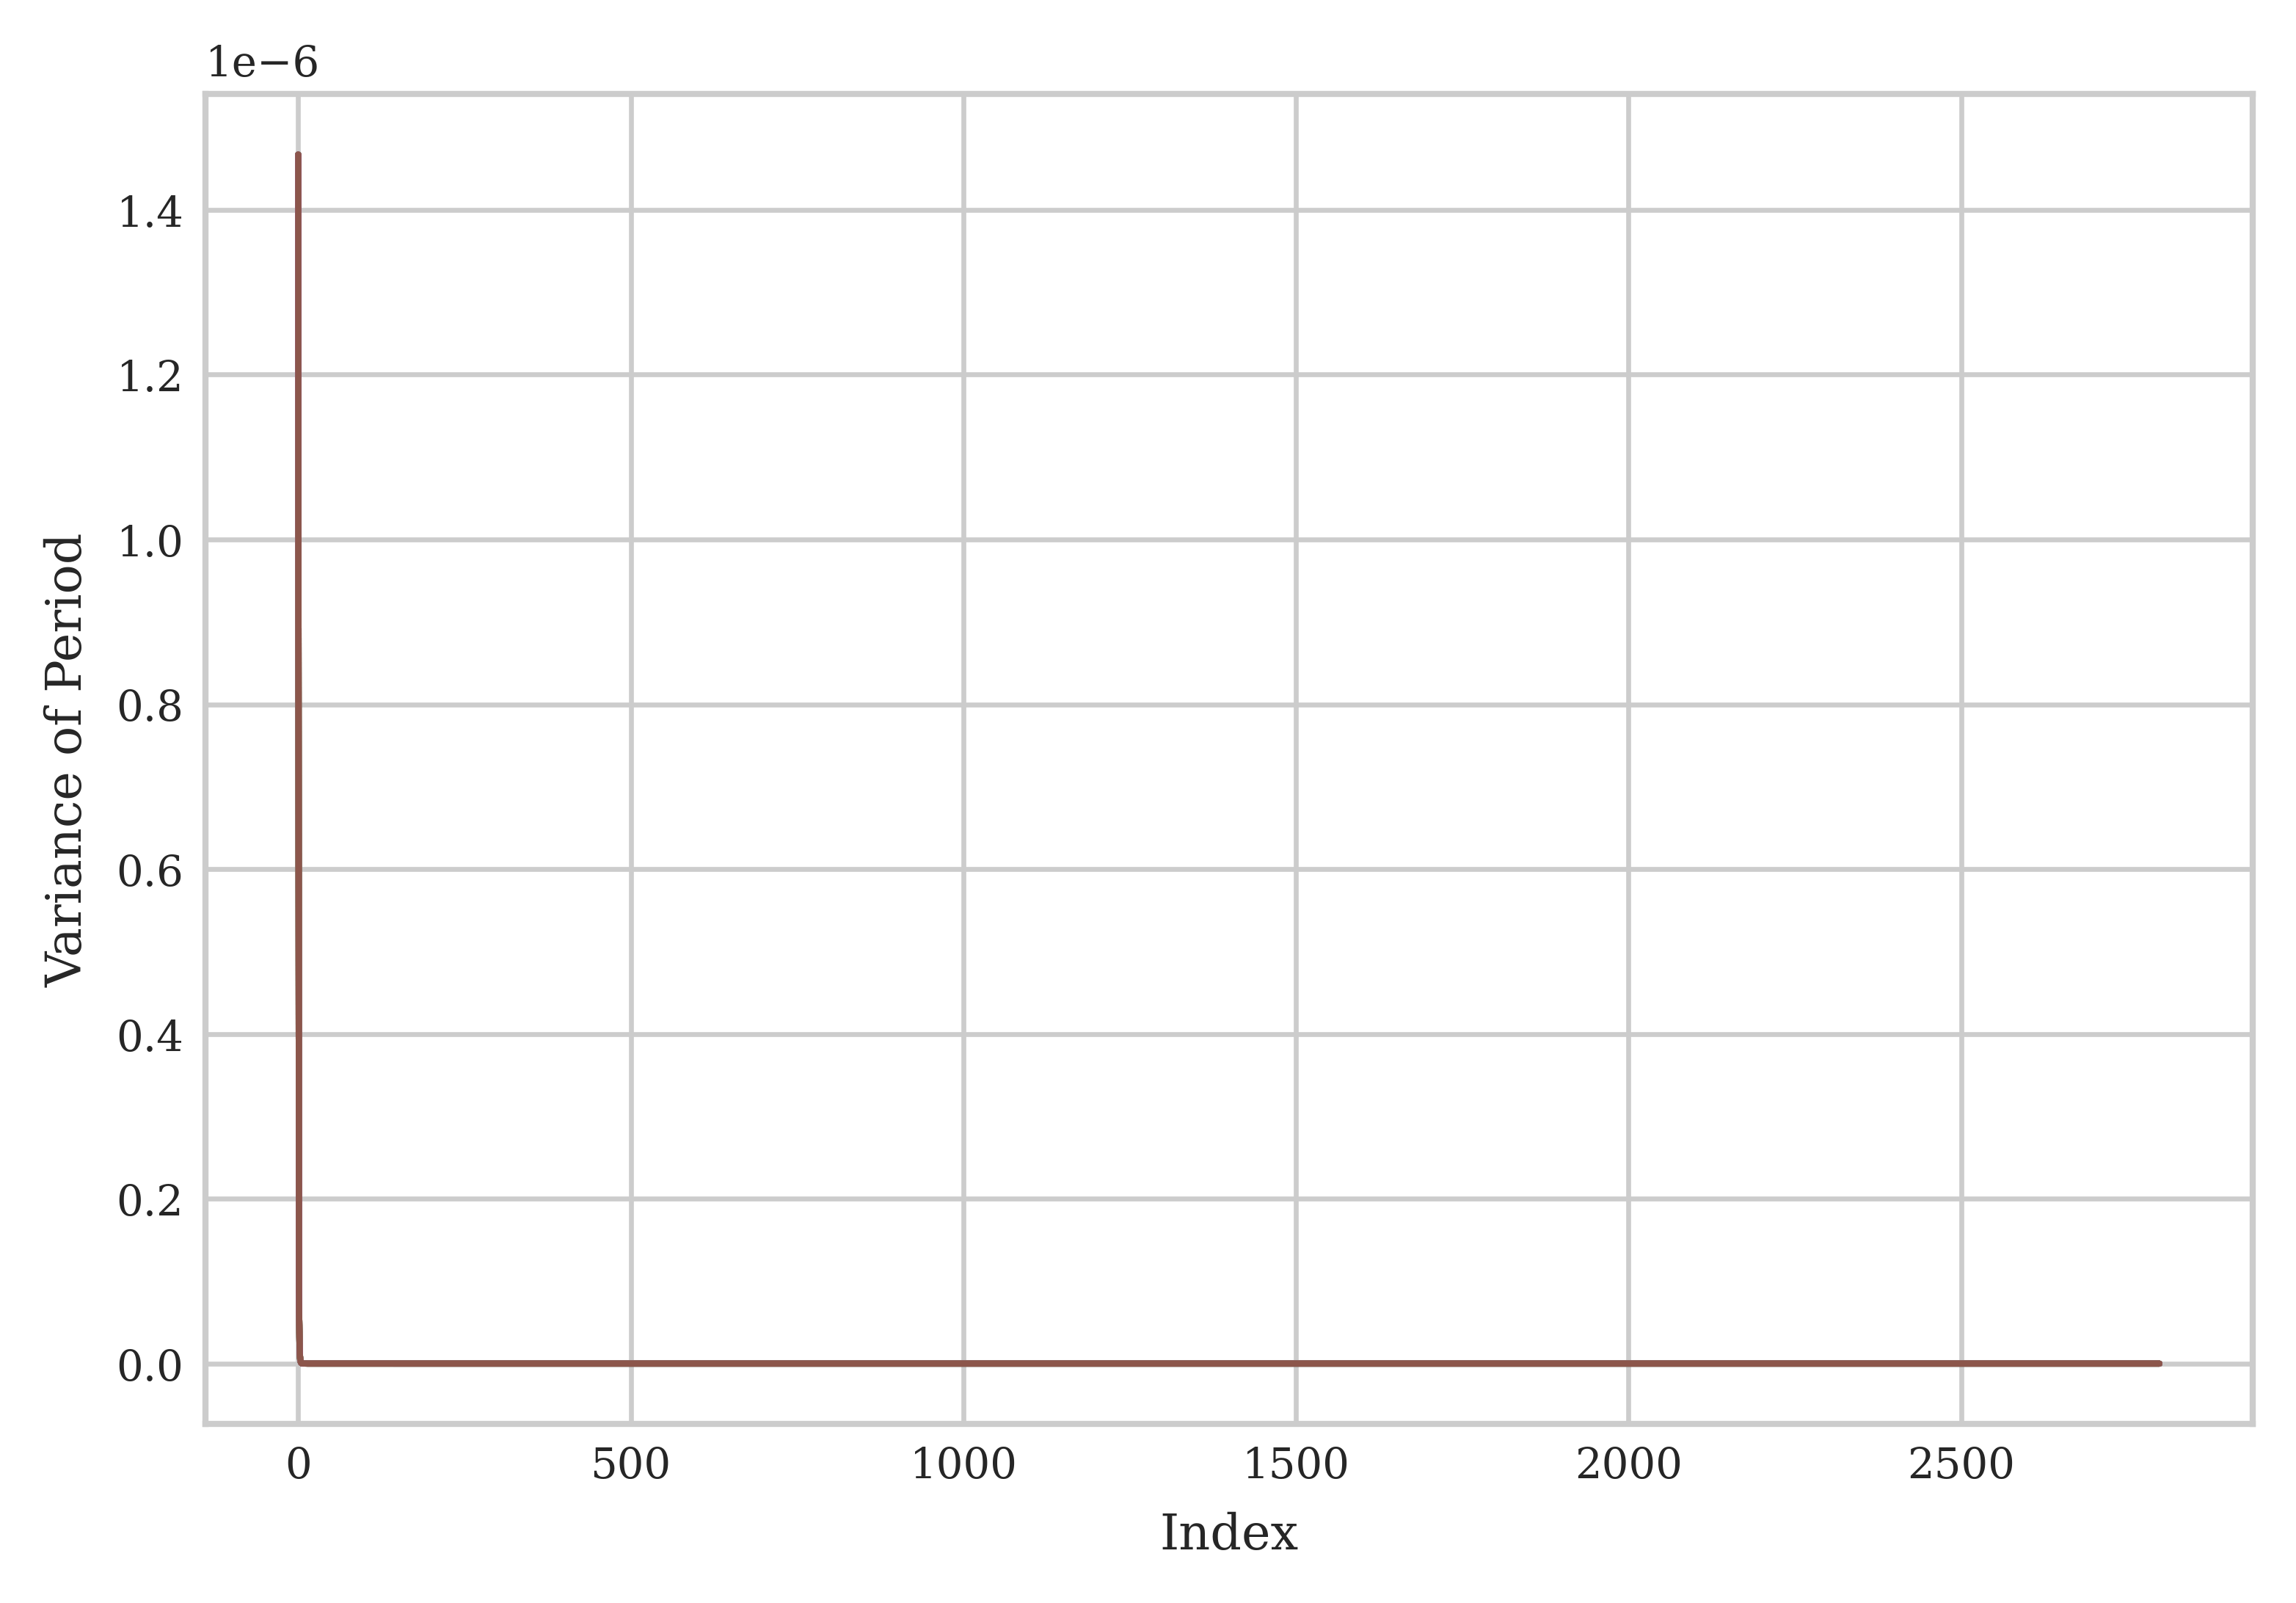

In [31]:
# PLOT PERIOD FOR ALL NODES
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
fig=plt.figure(dpi=600)
fig.set_size_inches(3.54,3.54)
period=torch.zeros(N,TT-1)
per_var=torch.zeros(TT-1)
for ind in range(TT-1):
    for i in range(N):
        period[i,ind]=torch.tensor(timenump[i,ind+1])-torch.tensor(timenump[i,ind])
    per_var[ind]=torch.var(period[:,ind])


for node in range(N):
    plt.plot(range(200,2798),(period[node,200:2798]), linewidth=1)
plt.xlabel('Index $(k)$', fontsize=8)
plt.ylabel('Period', fontsize=8)


period is: 0.005007743835449219


Text(0, 0.5, '$\\phi_i(k)$ mod $T_{c,DNN}(2799)$')

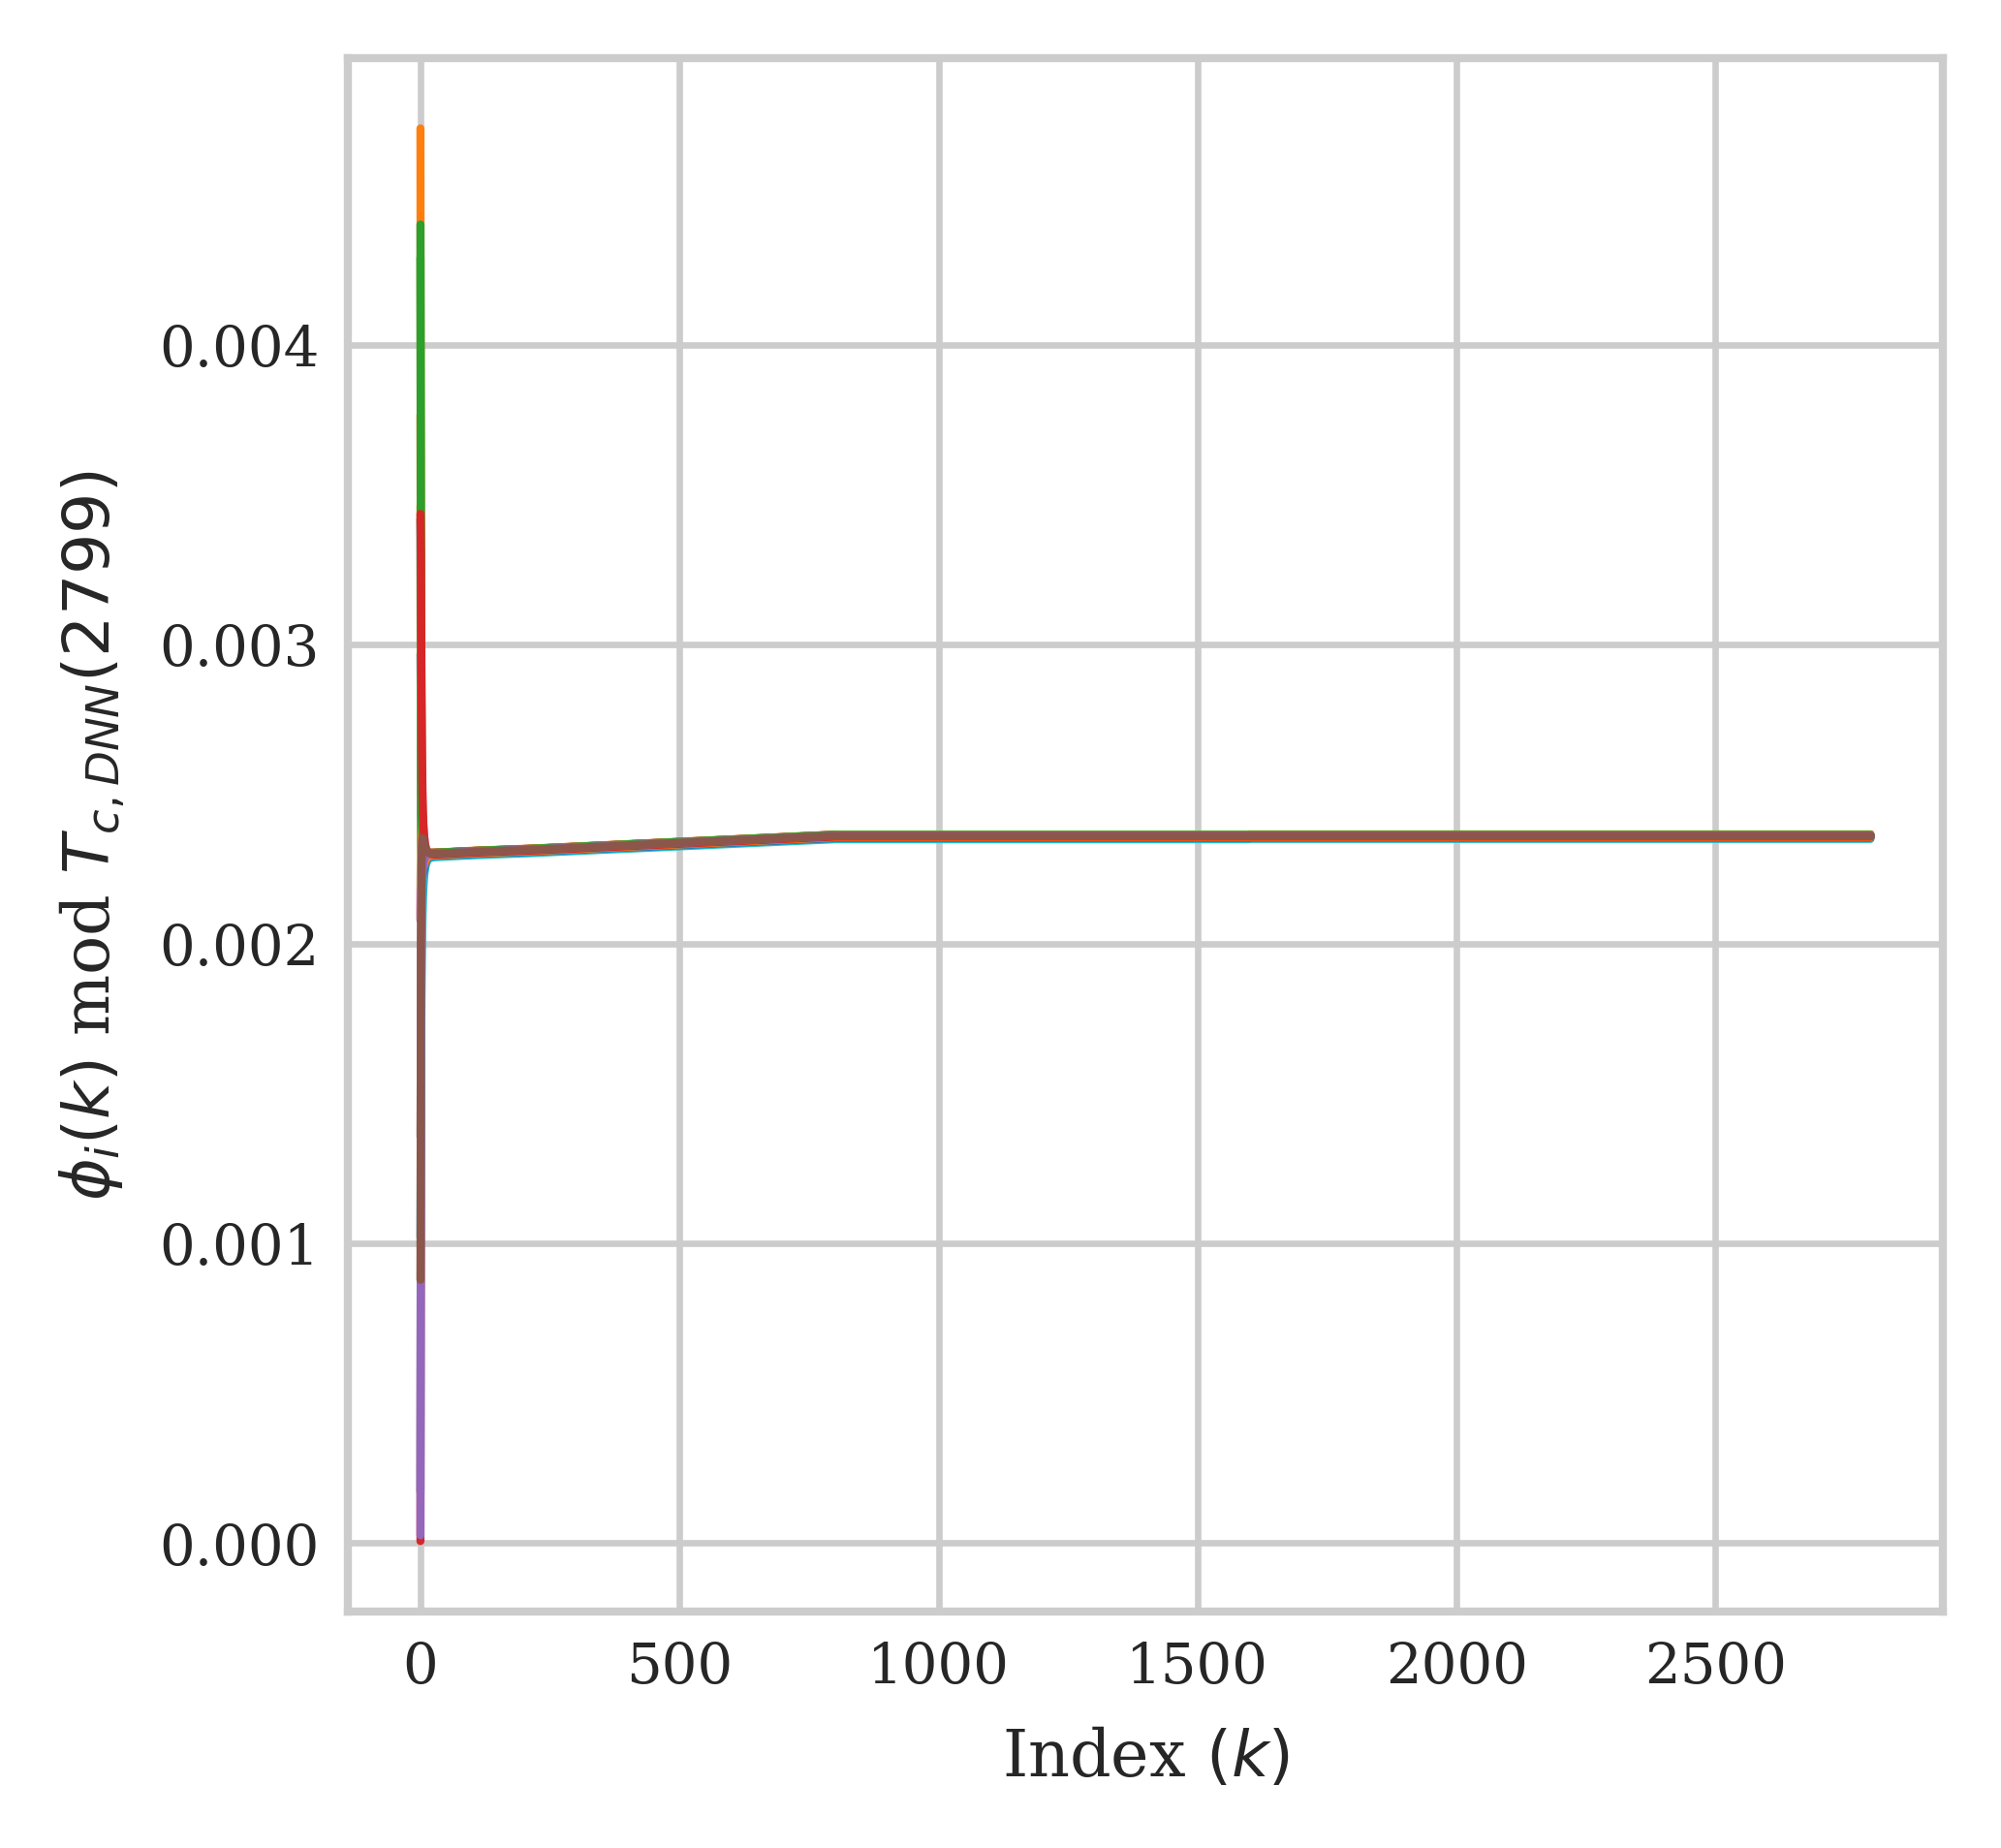

In [45]:
#\phi_i(k)$ mod $T_{c,DNN}(2799)
per_mean=torch.mean(torch.tensor(timenump[:,2799]-timenump[:, 2799-1]))
print('period is:', per_mean.detach().numpy())
fig=plt.figure(dpi=600)
fig.set_size_inches(3.54,3.54)
modulo=torch.tensor(timenump)%per_mean
for node in range(N):
    plt.plot(range(0,2800),modulo[node,0:2800], linewidth=1)
plt.xlabel('Index $(k)$', fontsize=8)
plt.ylabel('$\phi_i(k)$ mod $T_{c,DNN}(2799)$', fontsize=8)

# modulo

mean_norm_delay= 0.0002499523900209484
STD_norm_delay= 0.000837499318332331
Variance of NormDelay 7.014051082071191e-07


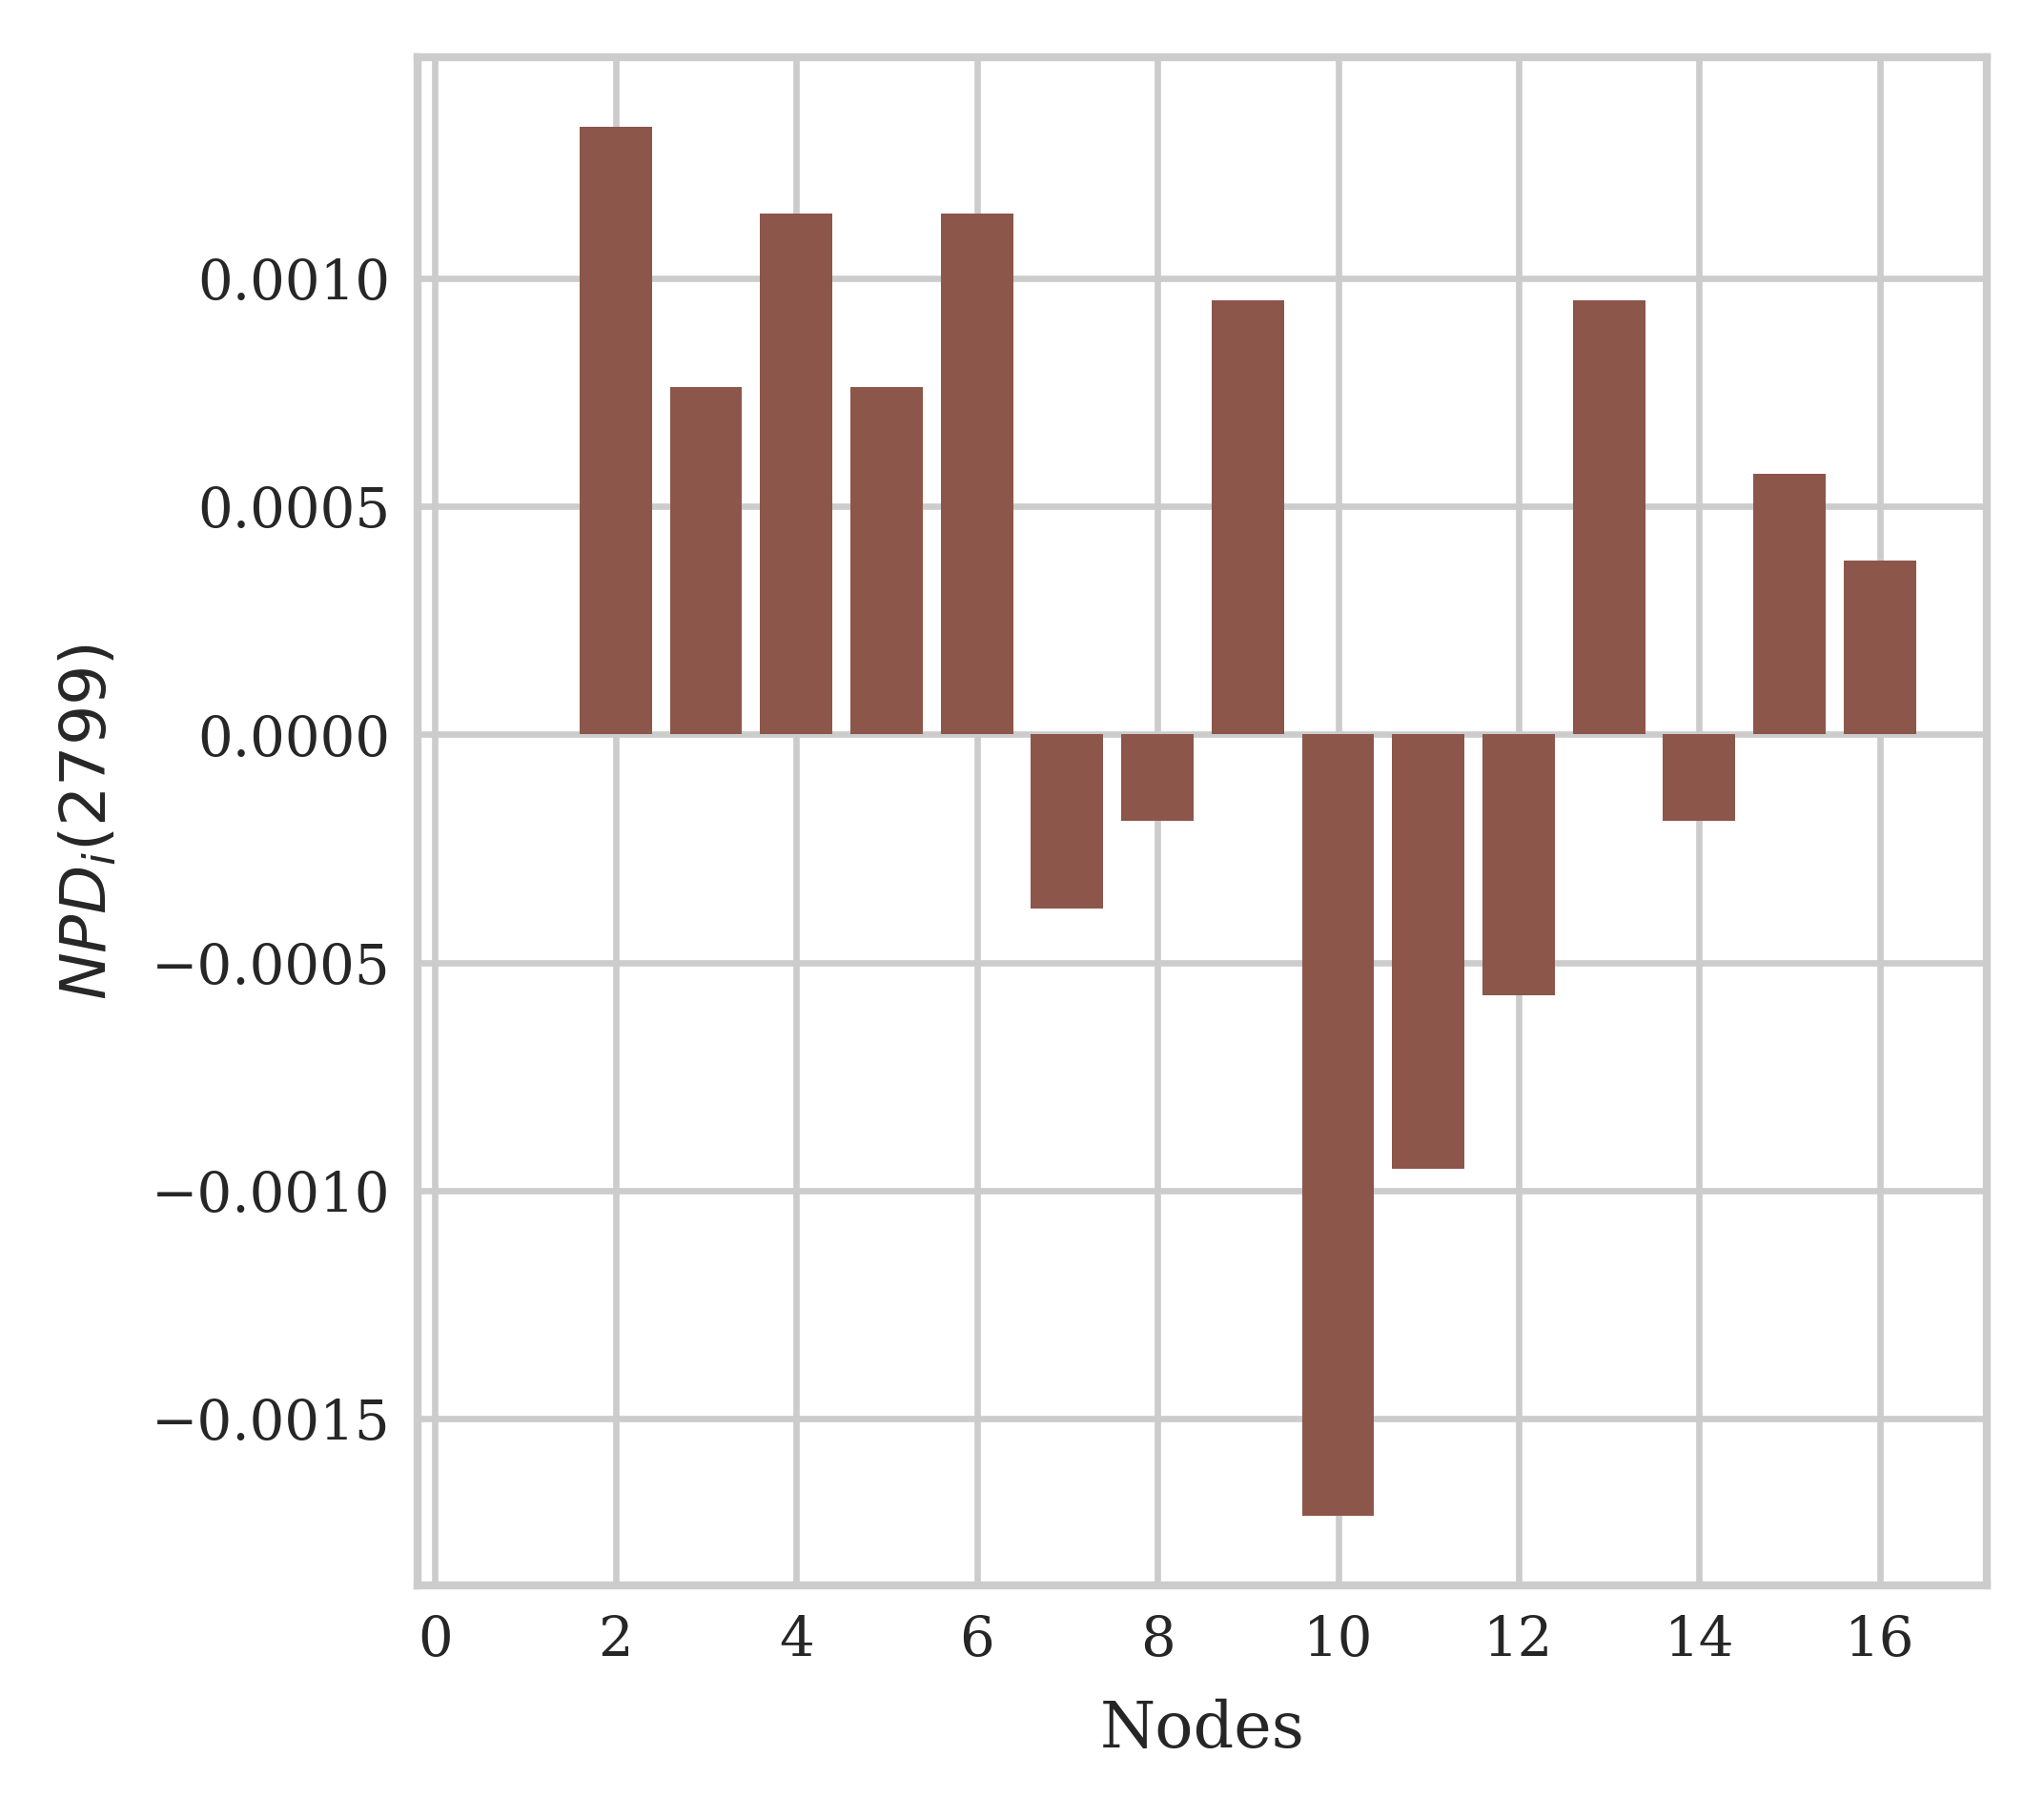

In [46]:
#PLOTTING NPD_i(2799)
norm_delay=np.empty([N,1])
# print(norm_delay)

for node in range(N):
    norm_delay[node]=(timenump[node,2799]-timenump[0,2799])/per_mean
    
fig=plt.figure(dpi=600)
fig.set_size_inches(3.54,3.54)

for node in range(N):
    plt.bar(range(N)+np.ones(N),norm_delay[:,0])
plt.xlabel('Nodes', fontsize=8)
plt.ylabel('$NPD_i(2799)$', fontsize=8)

mean_norm_delay=np.mean(norm_delay)
STD_norm_delay=np.std(norm_delay)
print('mean_norm_delay=', mean_norm_delay)
print('STD_norm_delay=', STD_norm_delay)
print('Variance of NormDelay', STD_norm_delay**2)

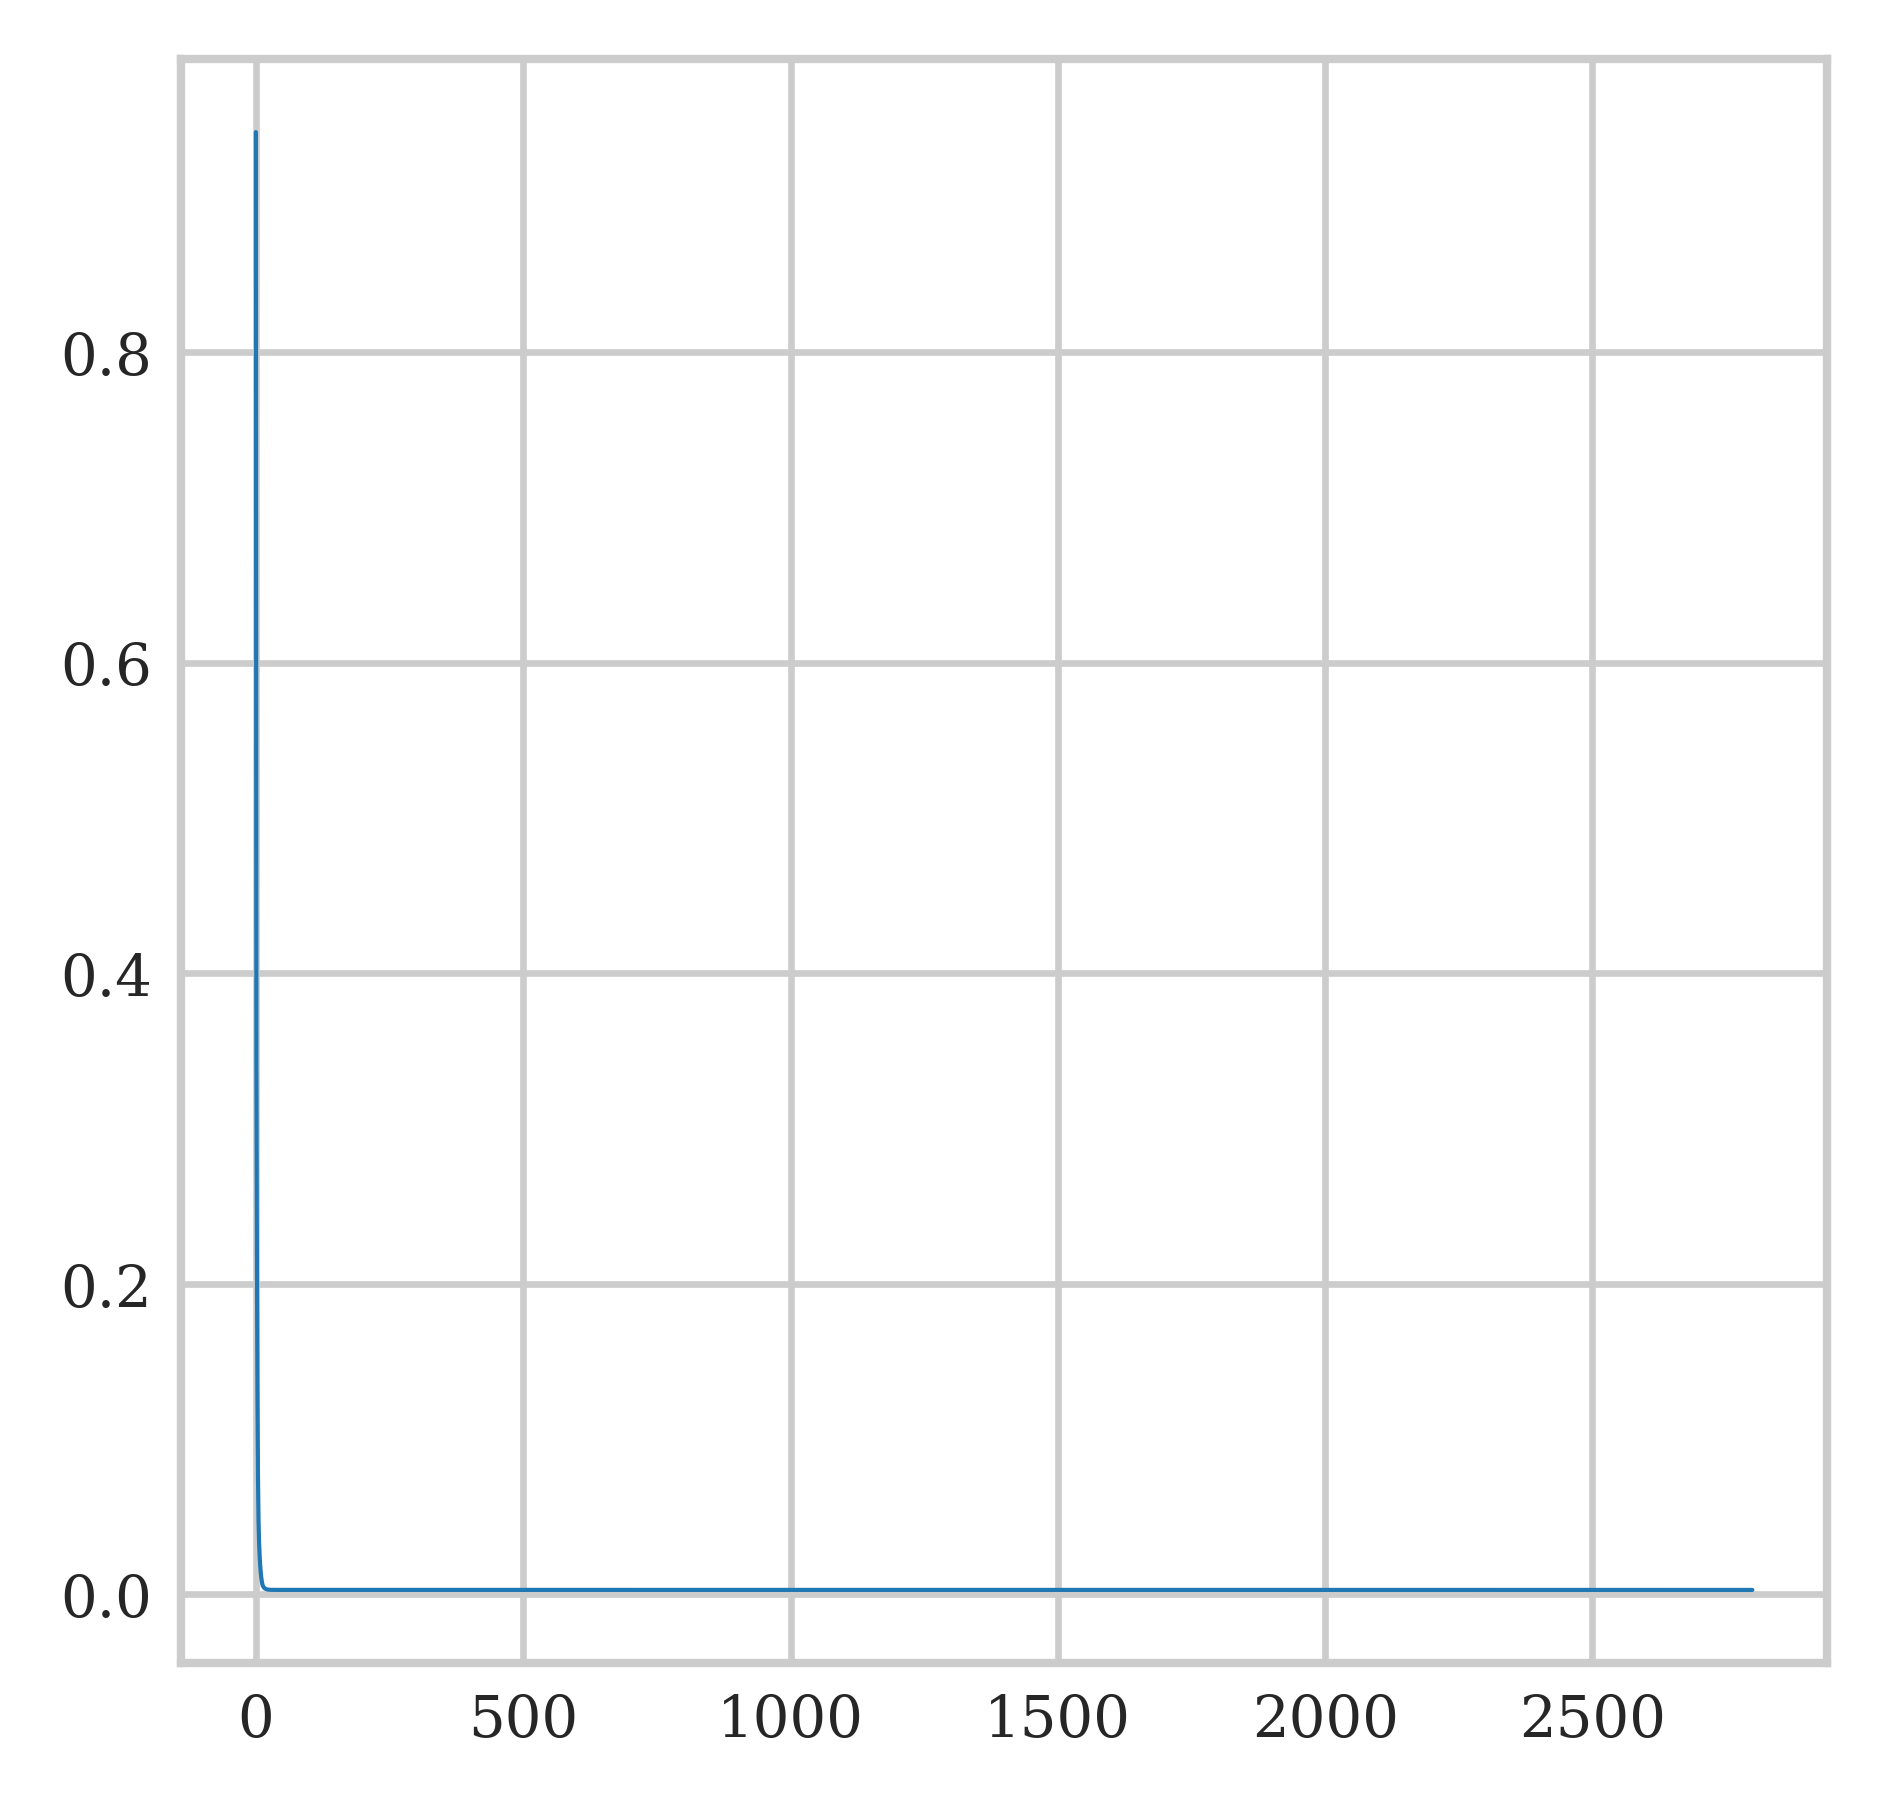

In [21]:
#PLOTTING NPD RANGE
MAT_norm_delay=np.zeros([N,TT])
MAT_Delay_spread=np.zeros((1,TT))
for ind in range(TT):
    for node in range(N):
        MAT_norm_delay[node,ind]=(timenump[node,ind]-timenump[0,ind])/per_mean
    MAT_Delay_spread[0,ind]=np.amax(MAT_norm_delay[:,ind])-np.amin(MAT_norm_delay[:,ind])
fig=plt.figure(dpi=600)
fig.set_size_inches(3.54,3.54)
plt.plot(range(0,TT),torch.tensor(MAT_Delay_spread[0,0:TT]), linewidth=0.5)


##### Testing with the other time indexes and changing clock phases for 5 nodes after periods of SncPer iterations

In [ ]:
for node in range(N):
            Weightdict[node]=Weight[node]
            diff=TrainData[node,0:N-1].clone() 
            prod=torch.sum(diff* Weightdict[node])
            NodeInst_time[node]=timenump[node,i].item() +Tnode[node].item() + (Eps0*prod)
            timenump[node,i+1]=NodeInst_time[node].detach().numpy() #Saving a detached version of the successive time
            

In [25]:
#Testing with the other time indexes and changing clock phases and Periods for 5 nodes after periods of SncPer iterations
t_new=torch.zeros(N,N)
SncPer=279 # represents the period of iterations after which the clocks lose synchrony
Nodeintest=torch.zeros(N,2*(N-1))
Sncbatch=int((TT-Tbatch)/SncPer)
Weight={}
# propdelay_mat=TimeOfFlight_Matrix.numpy()
for Pcnt in range(Sncbatch):
    print(Pcnt)
    for i in range(Tbatch+Pcnt*SncPer,Tbatch+Pcnt*SncPer+SncPer):
        for ii in range(N):
            for jj in range(N):
                with torch.no_grad():
                    t_new[ii,jj]=torch.tensor(timenump[ii,i]) + TimeOfFlight_Matrix[ii,jj].clone()
                    if (RSSI_Matrix[ii,jj]==0 and ii!=jj):
                        t_new[ii,jj]=0
        for b in range(N):
            Node=torch.cat([t_new[0:b,b],t_new[b+1:,b],RSSI_Matrix[b,0:b],RSSI_Matrix[b,b+1:]]) #let the NN TAKE IN JUST THE TIME AND NOT THE DIFFERENCE
            Nodeintest[b,:]=Node
            #Setting the input phase difference to be zero for uncoupled nodes
        for b in range(N):
            for ind in range(N-1):
                if Nodeintest[b,ind]!=0:
                    Nodeintest[b,ind]=Nodeintest[b,ind]-timenump[b,i]
                else:
                    Nodeintest[b,ind]=0
        
        if i<=TT-2:
            Weight=Dnn_Out(Nodeintest[:,:])

            for node in range(N):
                diff[node,:]=Nodeintest[node,0:N-1].reshape(1, (N-1))
                prod[0,node]=torch.sum(diff[node,:]* Weight[node])
                timenump[node,i+1]=timenump[node,i] +Tnode[node].item() + Eps0*prod[0,node] 
            
            if i+1==Tbatch+Pcnt*SncPer+SncPer:
                missclk=random.sample(range(N),5) #randly select some clocks which lose synchrony at the begining of each sncbatch.
                for clk in missclk:
                    timenump[clk,i+1]=timenump[clk,i+1]+ Tnode[clk]*np.random.rand(1,1)


0
1
2
3
4
5
6
7
8
9


Text(0, 0.5, 'Variance of Period')

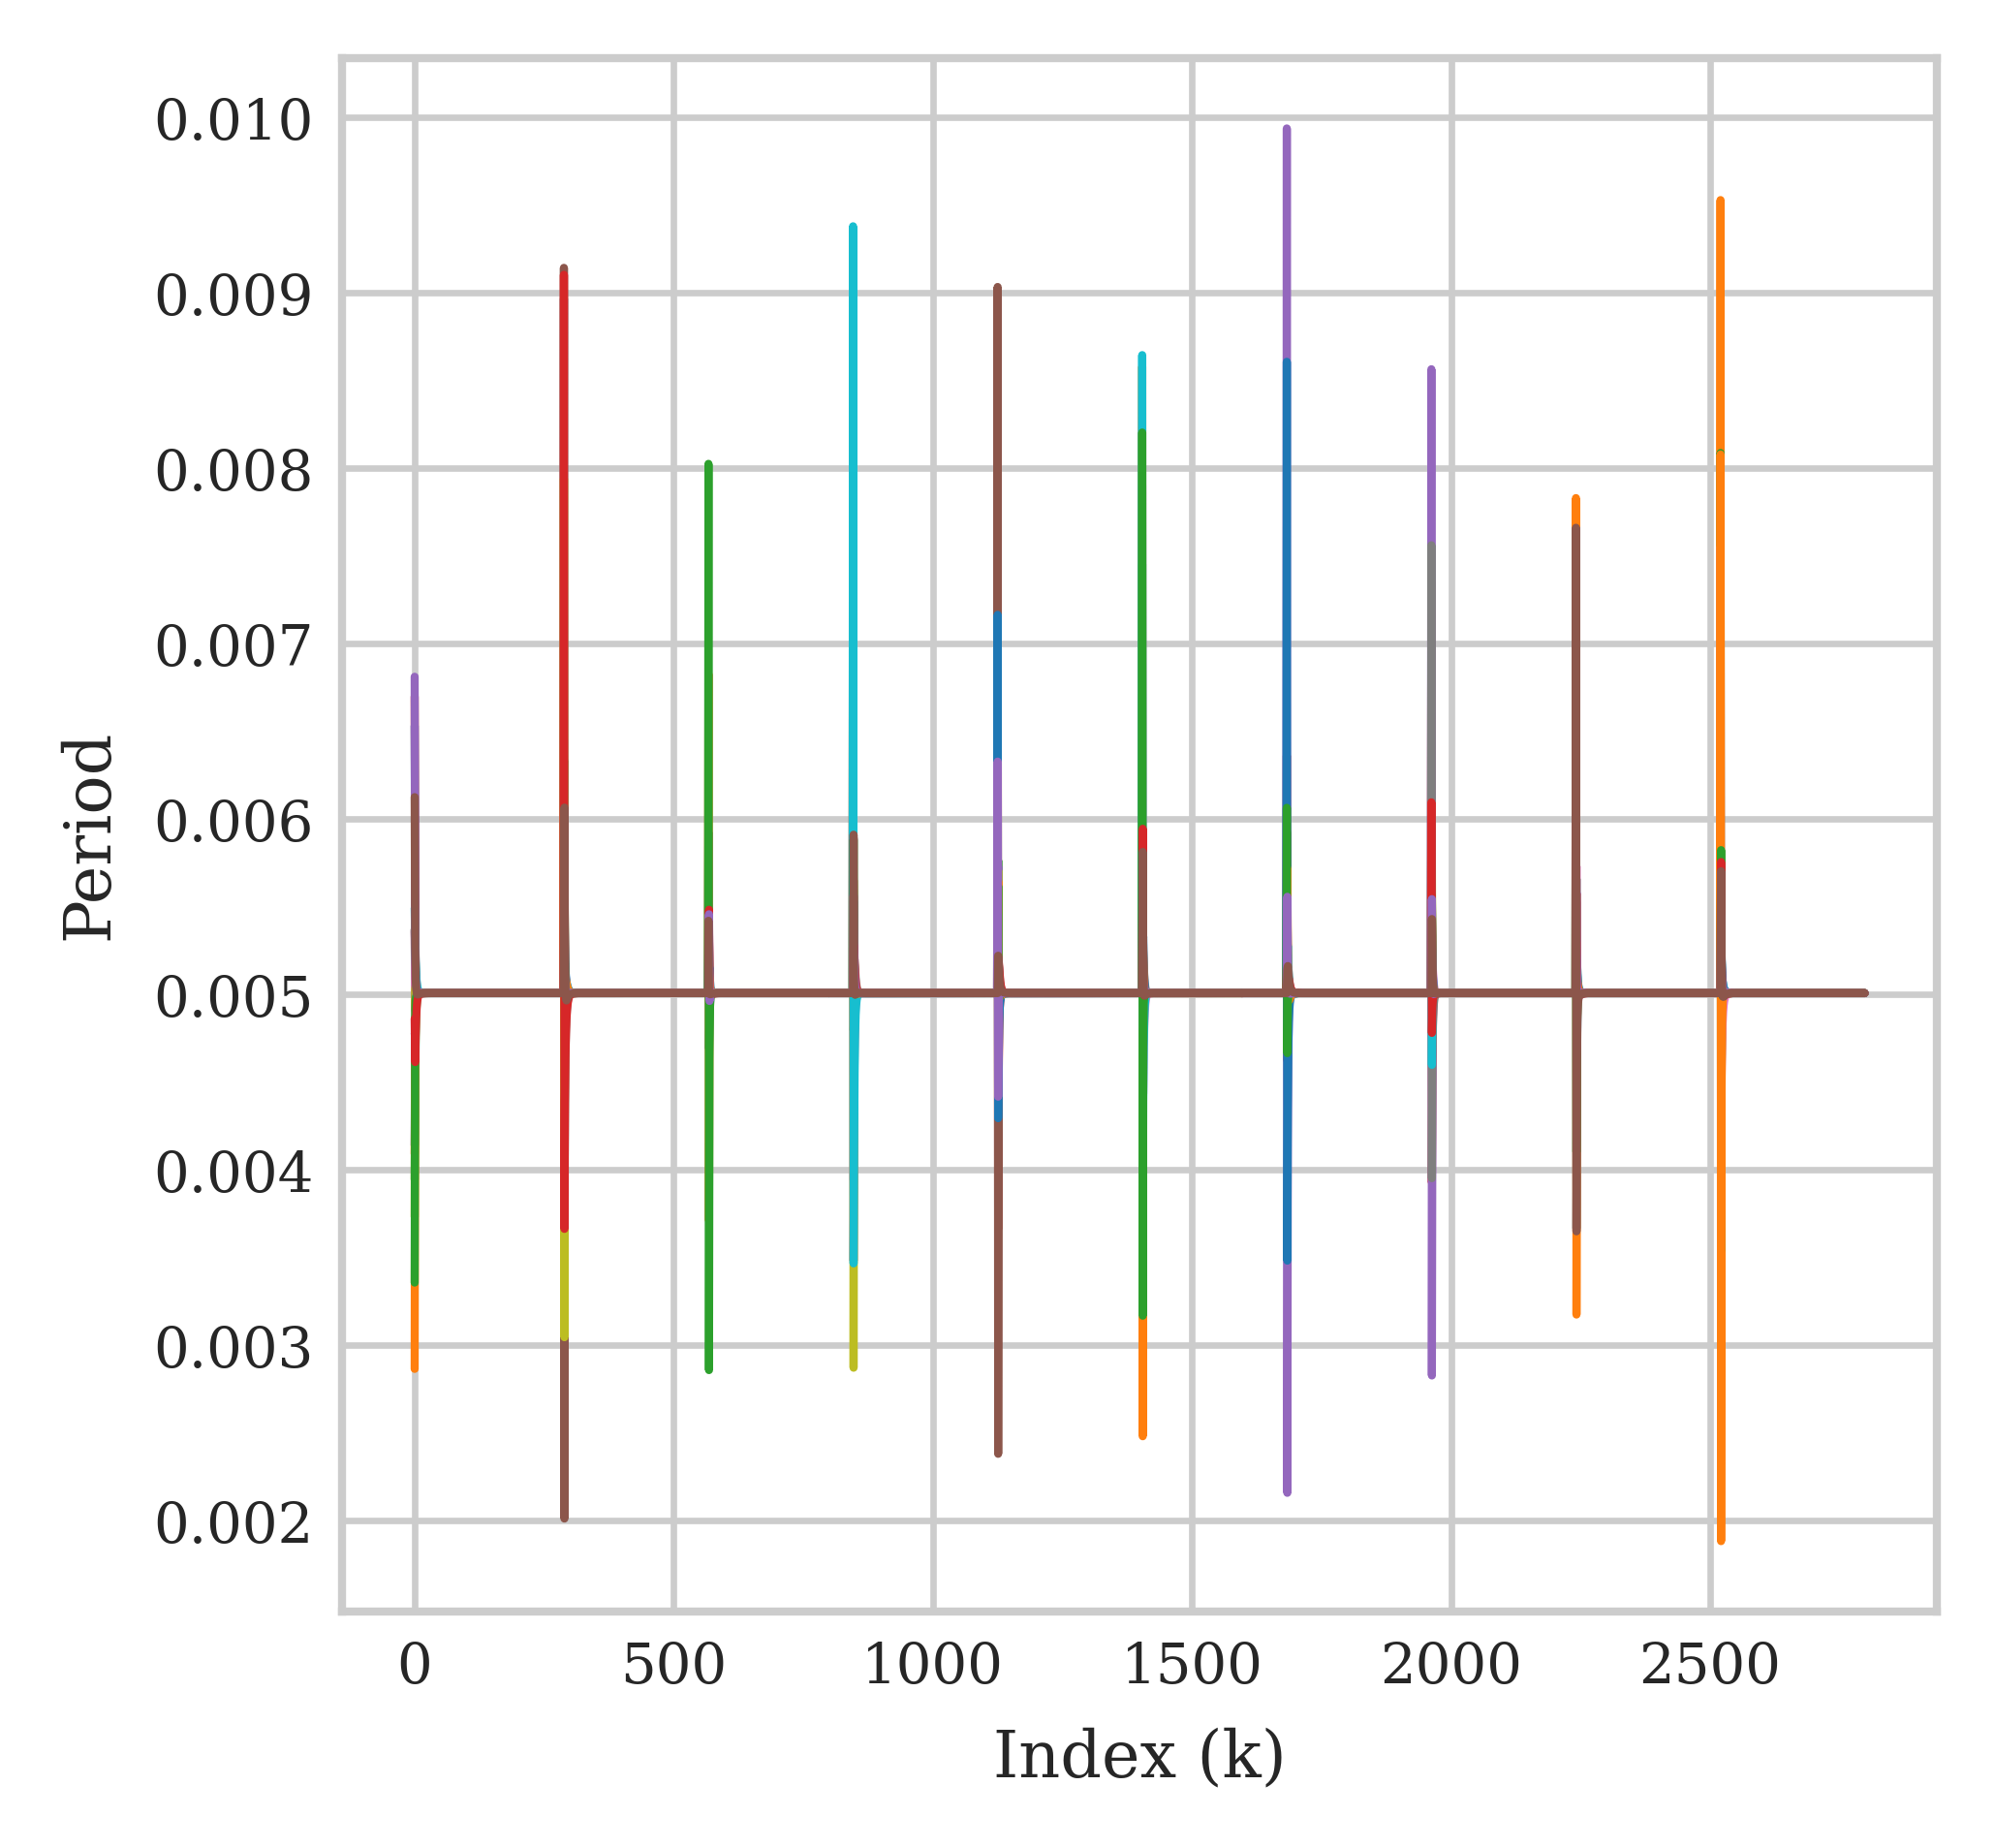

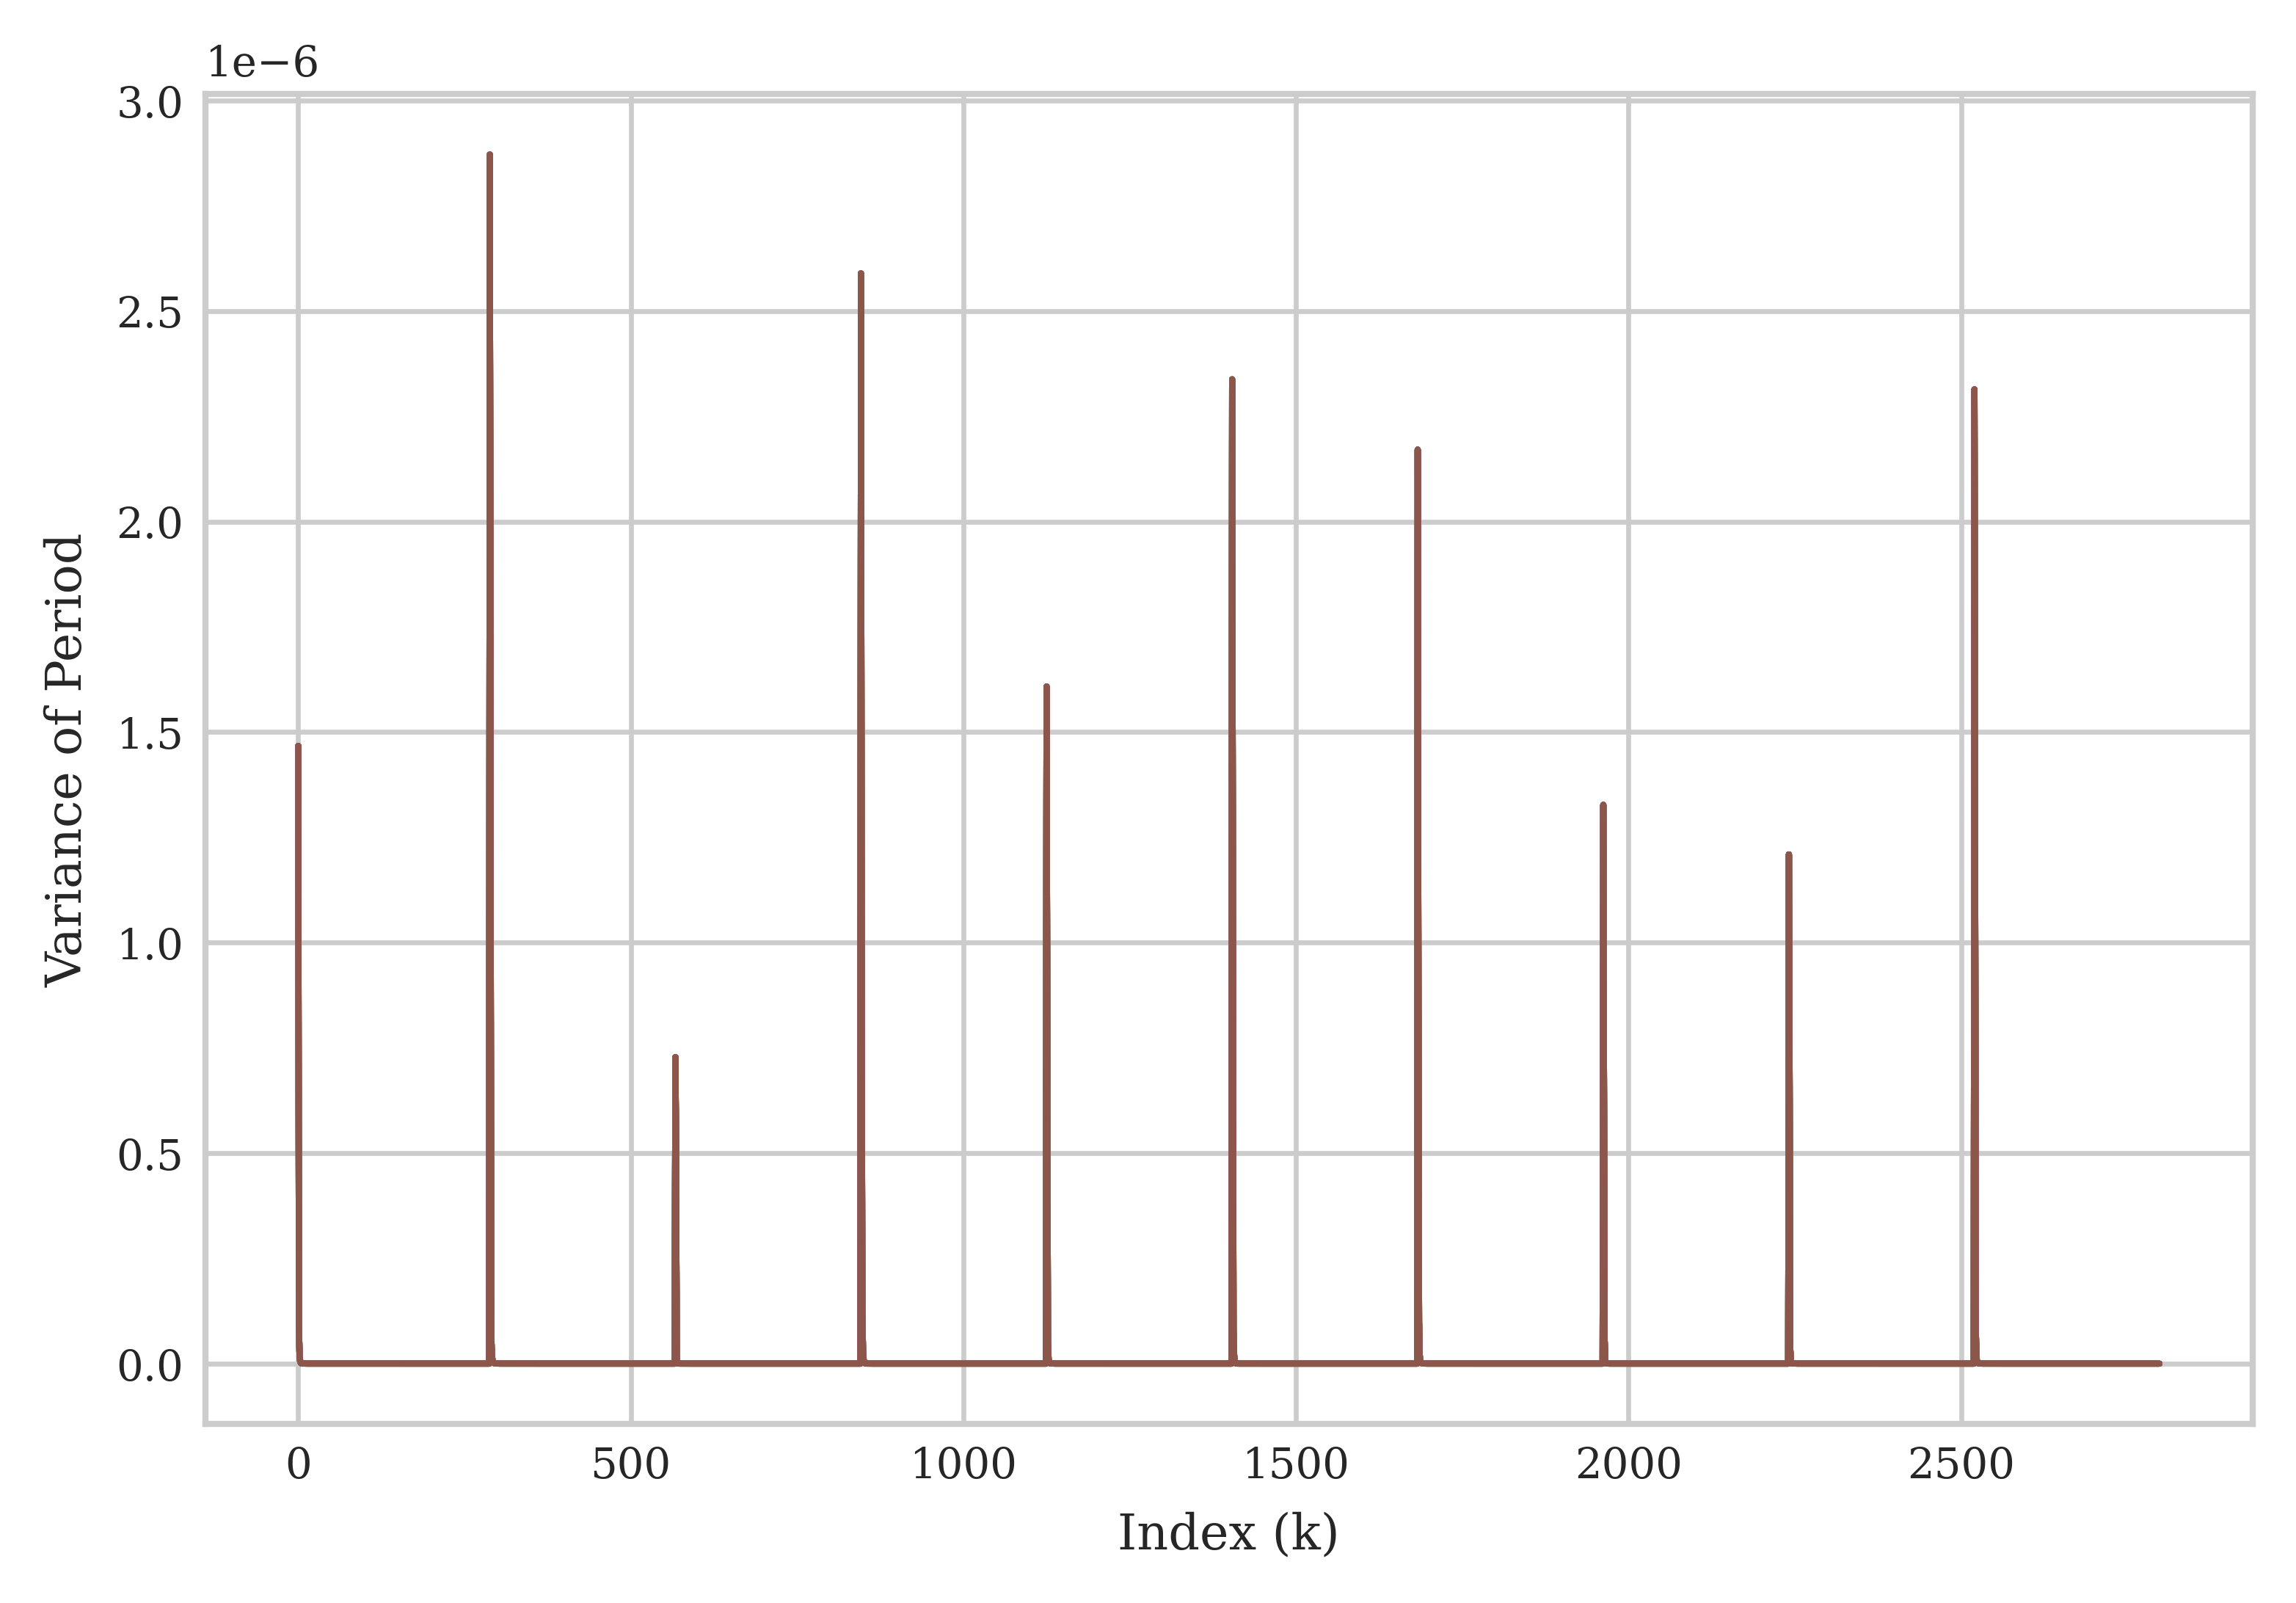

In [31]:
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
fig=plt.figure(dpi=600)
fig.set_size_inches(3.54,3.54)
period=torch.zeros(N,TT-1)
per_var=torch.zeros(TT-1)
for ind in range(TT-1):
    for i in range(N):
        period[i,ind]=torch.tensor(timenump[i,ind+1])-torch.tensor(timenump[i,ind])
    per_var[ind]=torch.var(period[:,ind])


for node in range(N):
    plt.plot(range(TT-1),(period[node,:]), linewidth=1)
plt.xlabel('Index (k)', fontsize=8)
plt.ylabel('Period', fontsize=8)

period is: 0.005007743835449219


Text(0, 0.5, '$\\phi_i(k)$ mod $T_{c,DNN}$')

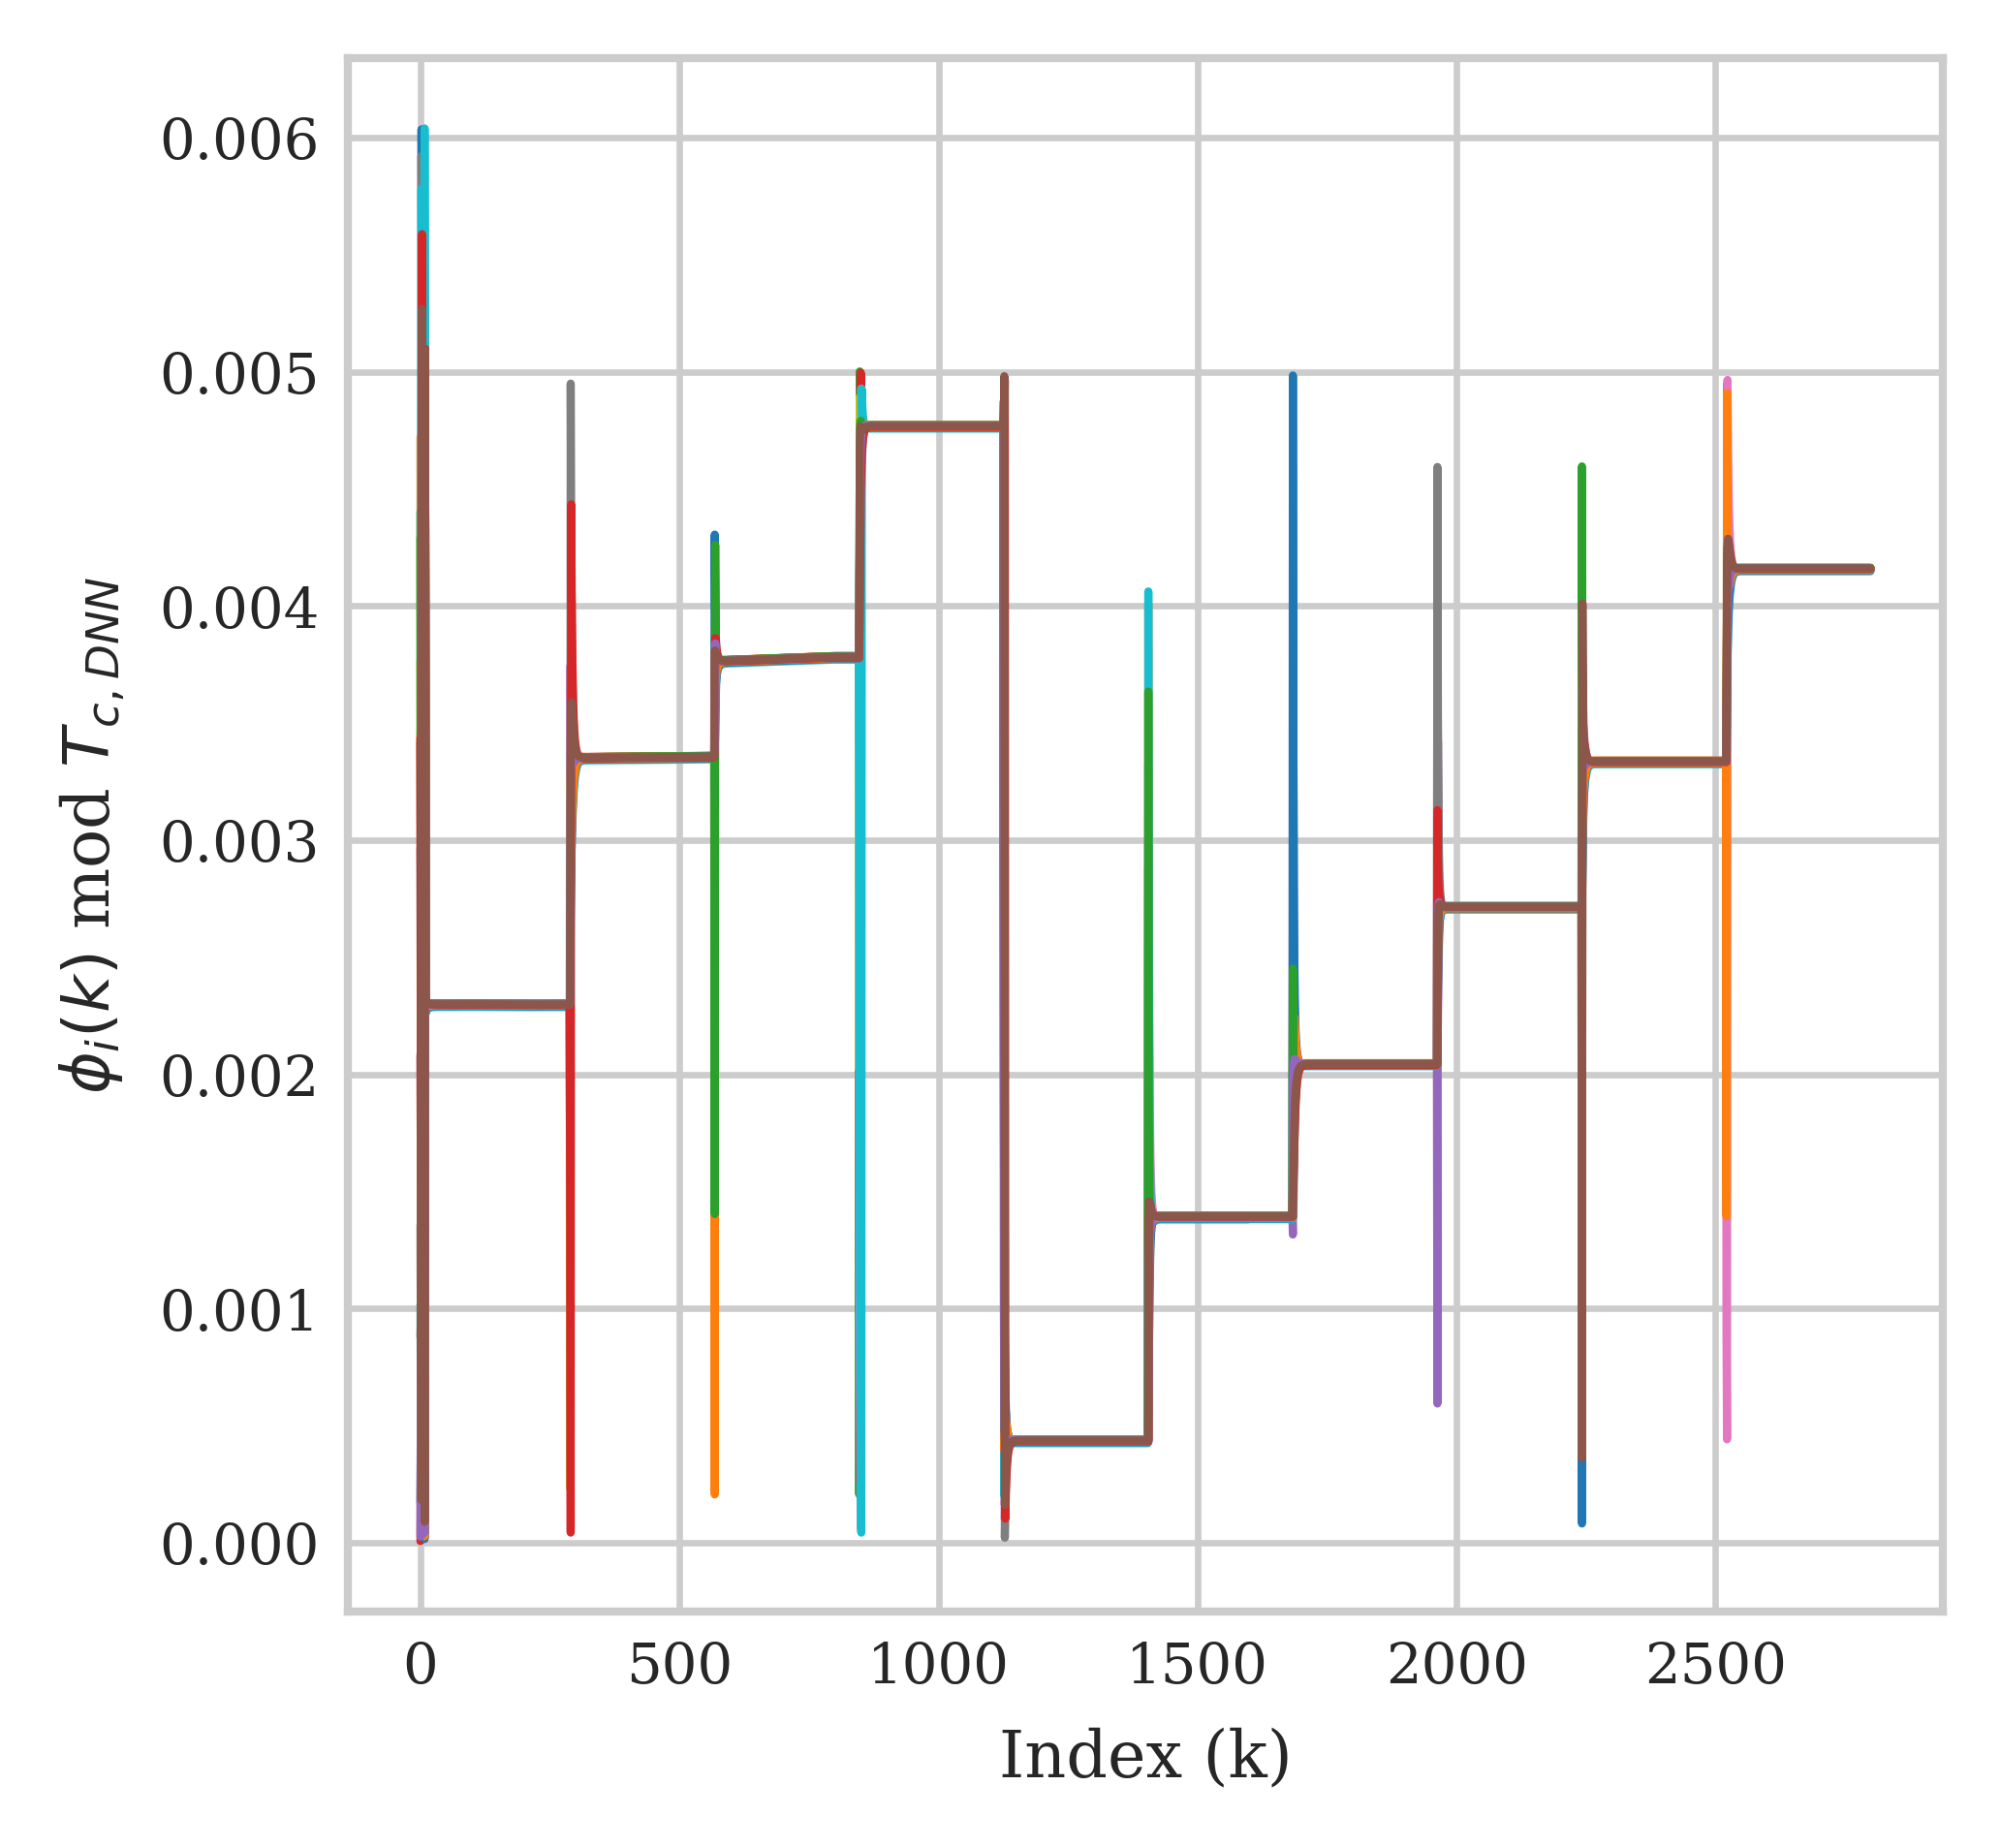

In [32]:
# MODULO PLOTS
modulo=torch.zeros((N,TT))
per_meanMatrix=torch.zeros((1,TT-1))
for ind in range(TT-1):
    per_meanMatrix[0,ind]=torch.mean(torch.tensor(timenump[:,ind+1]-timenump[:, ind]))

for ind in range(Tbatch):
    for node in range(N):
        modulo[node,ind]=torch.tensor(timenump[node,ind])%per_meanMatrix[0,Tbatch+SncPer-1]

for Pcnt in range(Sncbatch):
    modInd=Tbatch+Pcnt*SncPer+SncPer
    refind=modInd-2
    for ind in range(Tbatch+Pcnt*SncPer,modInd):
        for node in range(N):
            modulo[node,ind]=torch.tensor(timenump[node,ind])%per_meanMatrix[0,refind]


per_mean=torch.mean(torch.tensor(timenump[:,2799]-timenump[:, 2799-1]))
print('period is:', per_mean.detach().numpy())
fig=plt.figure(dpi=600)
fig.set_size_inches(3.54,3.54)
for node in range(N):
    plt.plot(modulo[node,:], linewidth=1)
plt.xlabel('Index (k)', fontsize=8)
plt.ylabel('$\phi_i(k)$ mod $T_{c,DNN}$', fontsize=8)

# modulo

In [33]:
# save('clockphasesFixedtrain_Phasereset',timenump)

minimum delay spread is: 0.0024757189106836795


Text(0, 0.5, 'NPD range')

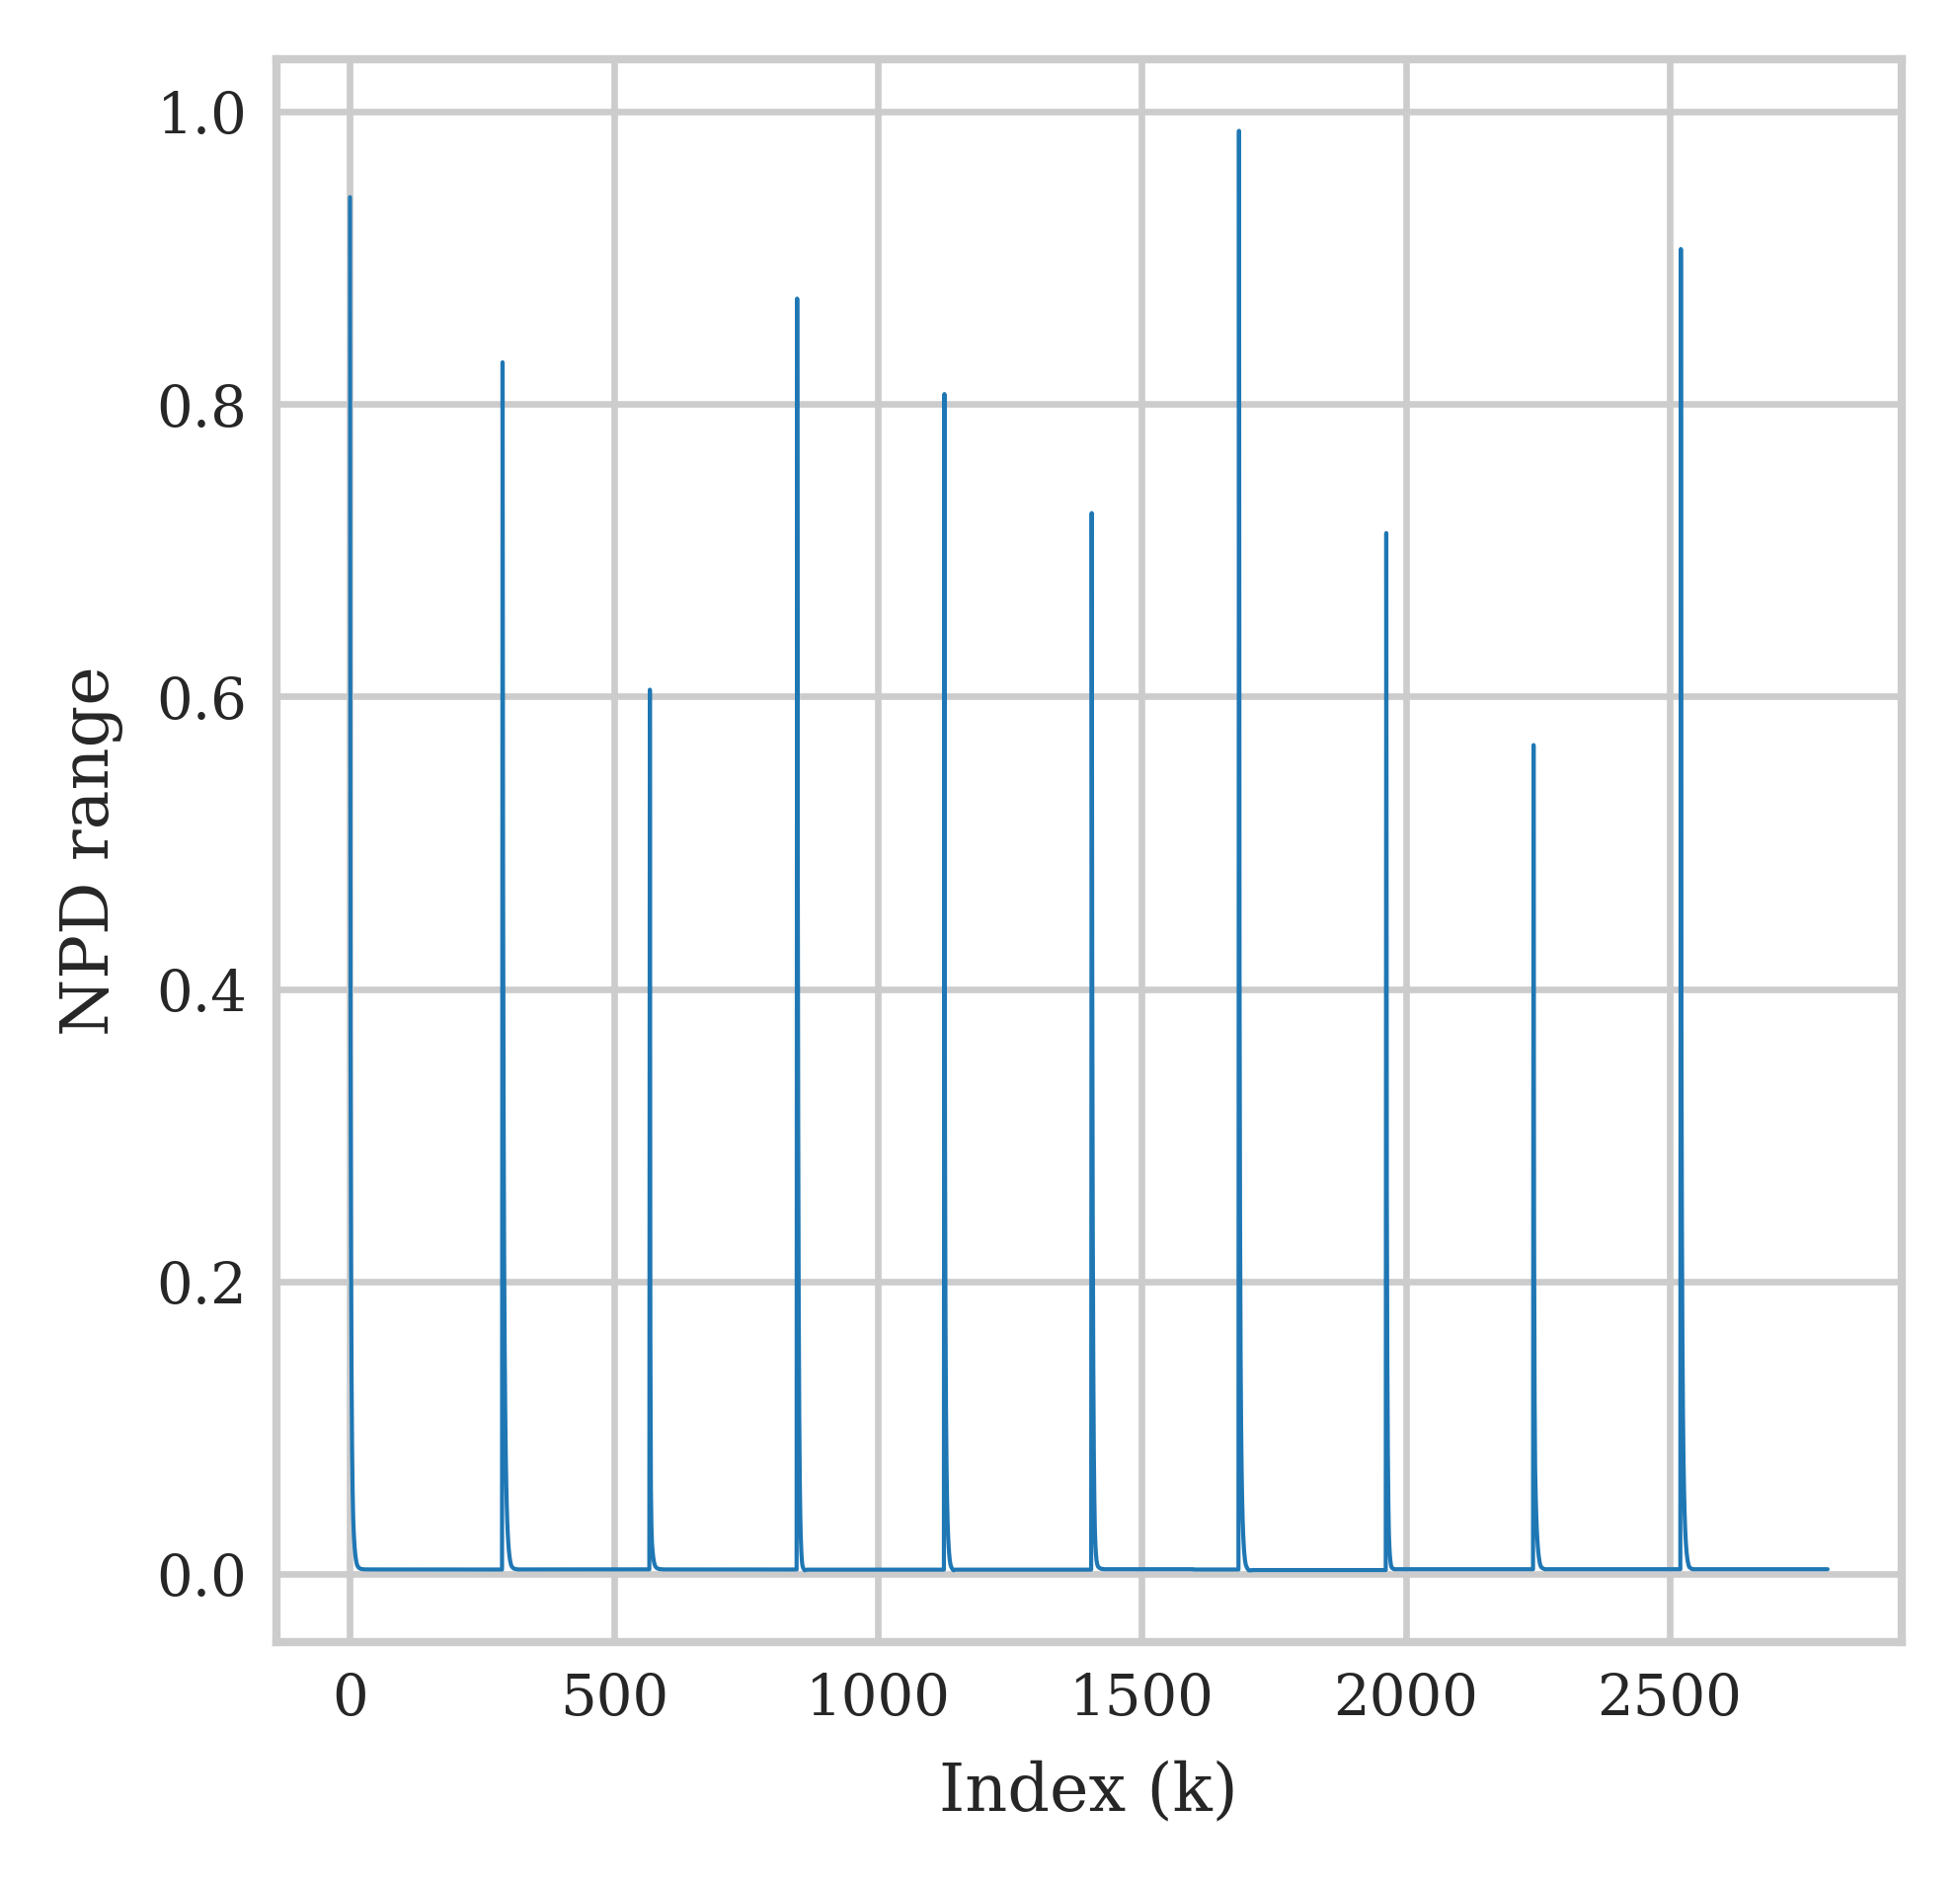

In [38]:
# NPD RANGE
MAT_norm_delay=np.zeros([N,TT])
MAT_Delay_spread=np.zeros((1,TT))
for ind in range(TT):
    for node in range(N):
        MAT_norm_delay[node,ind]=(timenump[node,ind]-timenump[0,ind])/per_mean
    MAT_Delay_spread[0,ind]=np.amax(MAT_norm_delay[:,ind])-np.amin(MAT_norm_delay[:,ind])
fig=plt.figure(dpi=600)
fig.set_size_inches(3.54,3.54)
# plt.ylim([0.00220,0.0038])
plt.plot(range(0,TT),torch.tensor(MAT_Delay_spread[0,0:TT]), linewidth=0.5)
print('minimum delay spread is:', np.min(MAT_Delay_spread))
plt.xlabel('Index (k)', fontsize=8)
plt.ylabel('NPD range', fontsize=8)

##### Testing with the other time indexes and changing clock phases and Period Tnode for 5 nodes after periods of SncPer iterations

In [16]:
t_new=torch.zeros(N,N)
TT=2800
SncPer=279 # represents the period of iterations after which the clocks lose synchrony
Nodeintest=torch.zeros(N,2*(N-1))
Sncbatch=int((TT-Tbatch)/SncPer)
for Pcnt in range(Sncbatch):
    print(Pcnt)
    for i in range(Tbatch+Pcnt*SncPer,Tbatch+Pcnt*SncPer+SncPer):
        for ii in range(N):
            for jj in range(N):
                with torch.no_grad():
                    t_new[ii,jj]=torch.tensor(timenump[ii,i]) + TimeOfFlight_Matrix[ii,jj].clone()
                    if (RSSI_Matrix[ii,jj]==0 and ii!=jj):
                        t_new[ii,jj]=0
    
        for b in range(N):
            Node=torch.cat([t_new[0:b,b],t_new[b+1:,b],RSSI_Matrix[b,0:b],RSSI_Matrix[b,b+1:]]) #let the NN TAKE IN JUST THE TIME AND NOT THE DIFFERENCE
            Nodeintest[b,:]=Node
        #Setting the input phase difference to be zero for uncoupled nodes
        for b in range(N):
            for ind in range(N-1):
                if Nodeintest[b,ind]!=0:
                    Nodeintest[b,ind]=Nodeintest[b,ind]-timenump[b,i]
                else:
                    Nodeintest[b,ind]=0
         
            
        if i<=TT-2:
            Weight=Dnn_Out(Nodeintest[:,:])

            for node in range(N):
                diff[node,:]=Nodeintest[node,0:N-1].reshape(1, (N-1))
                prod[0,node]=torch.sum(diff[node,:]* Weight[node])
                timenump[node,i+1]=timenump[node,i] +Tnode[node].item() + Eps0*prod[0,node] 
            
            if i+1==Tbatch+Pcnt*SncPer+SncPer:
                missclk=random.sample(range(N),5) #randly select some clocks which lose synchrony at the begining of each sncbatch.
                #RESETTING THE INDIVIDUAL Ti FOR SELCTED NODES
                a=1/(10**(torch.FloatTensor(len(missclk), 1).uniform_(4, 6)))
                b=torch.FloatTensor(len(missclk),1).uniform_(-1,1)
                for ind in range(len(missclk)):
                    if b[ind]<0:
                        b[ind]=-1
                    else:
                        b[ind]=1
                cnt=0   
                for clk in missclk:
                    Tnode[clk]=Time_res*(1+b[cnt]*a[cnt])
                    timenump[clk,i+1]=timenump[clk,i+1]+ Tnode[clk]*np.random.rand(1,1)
                    cnt+=1

0
1
2
3
4
5
6
7
8
9


Text(0, 0.5, 'Variance of Period')

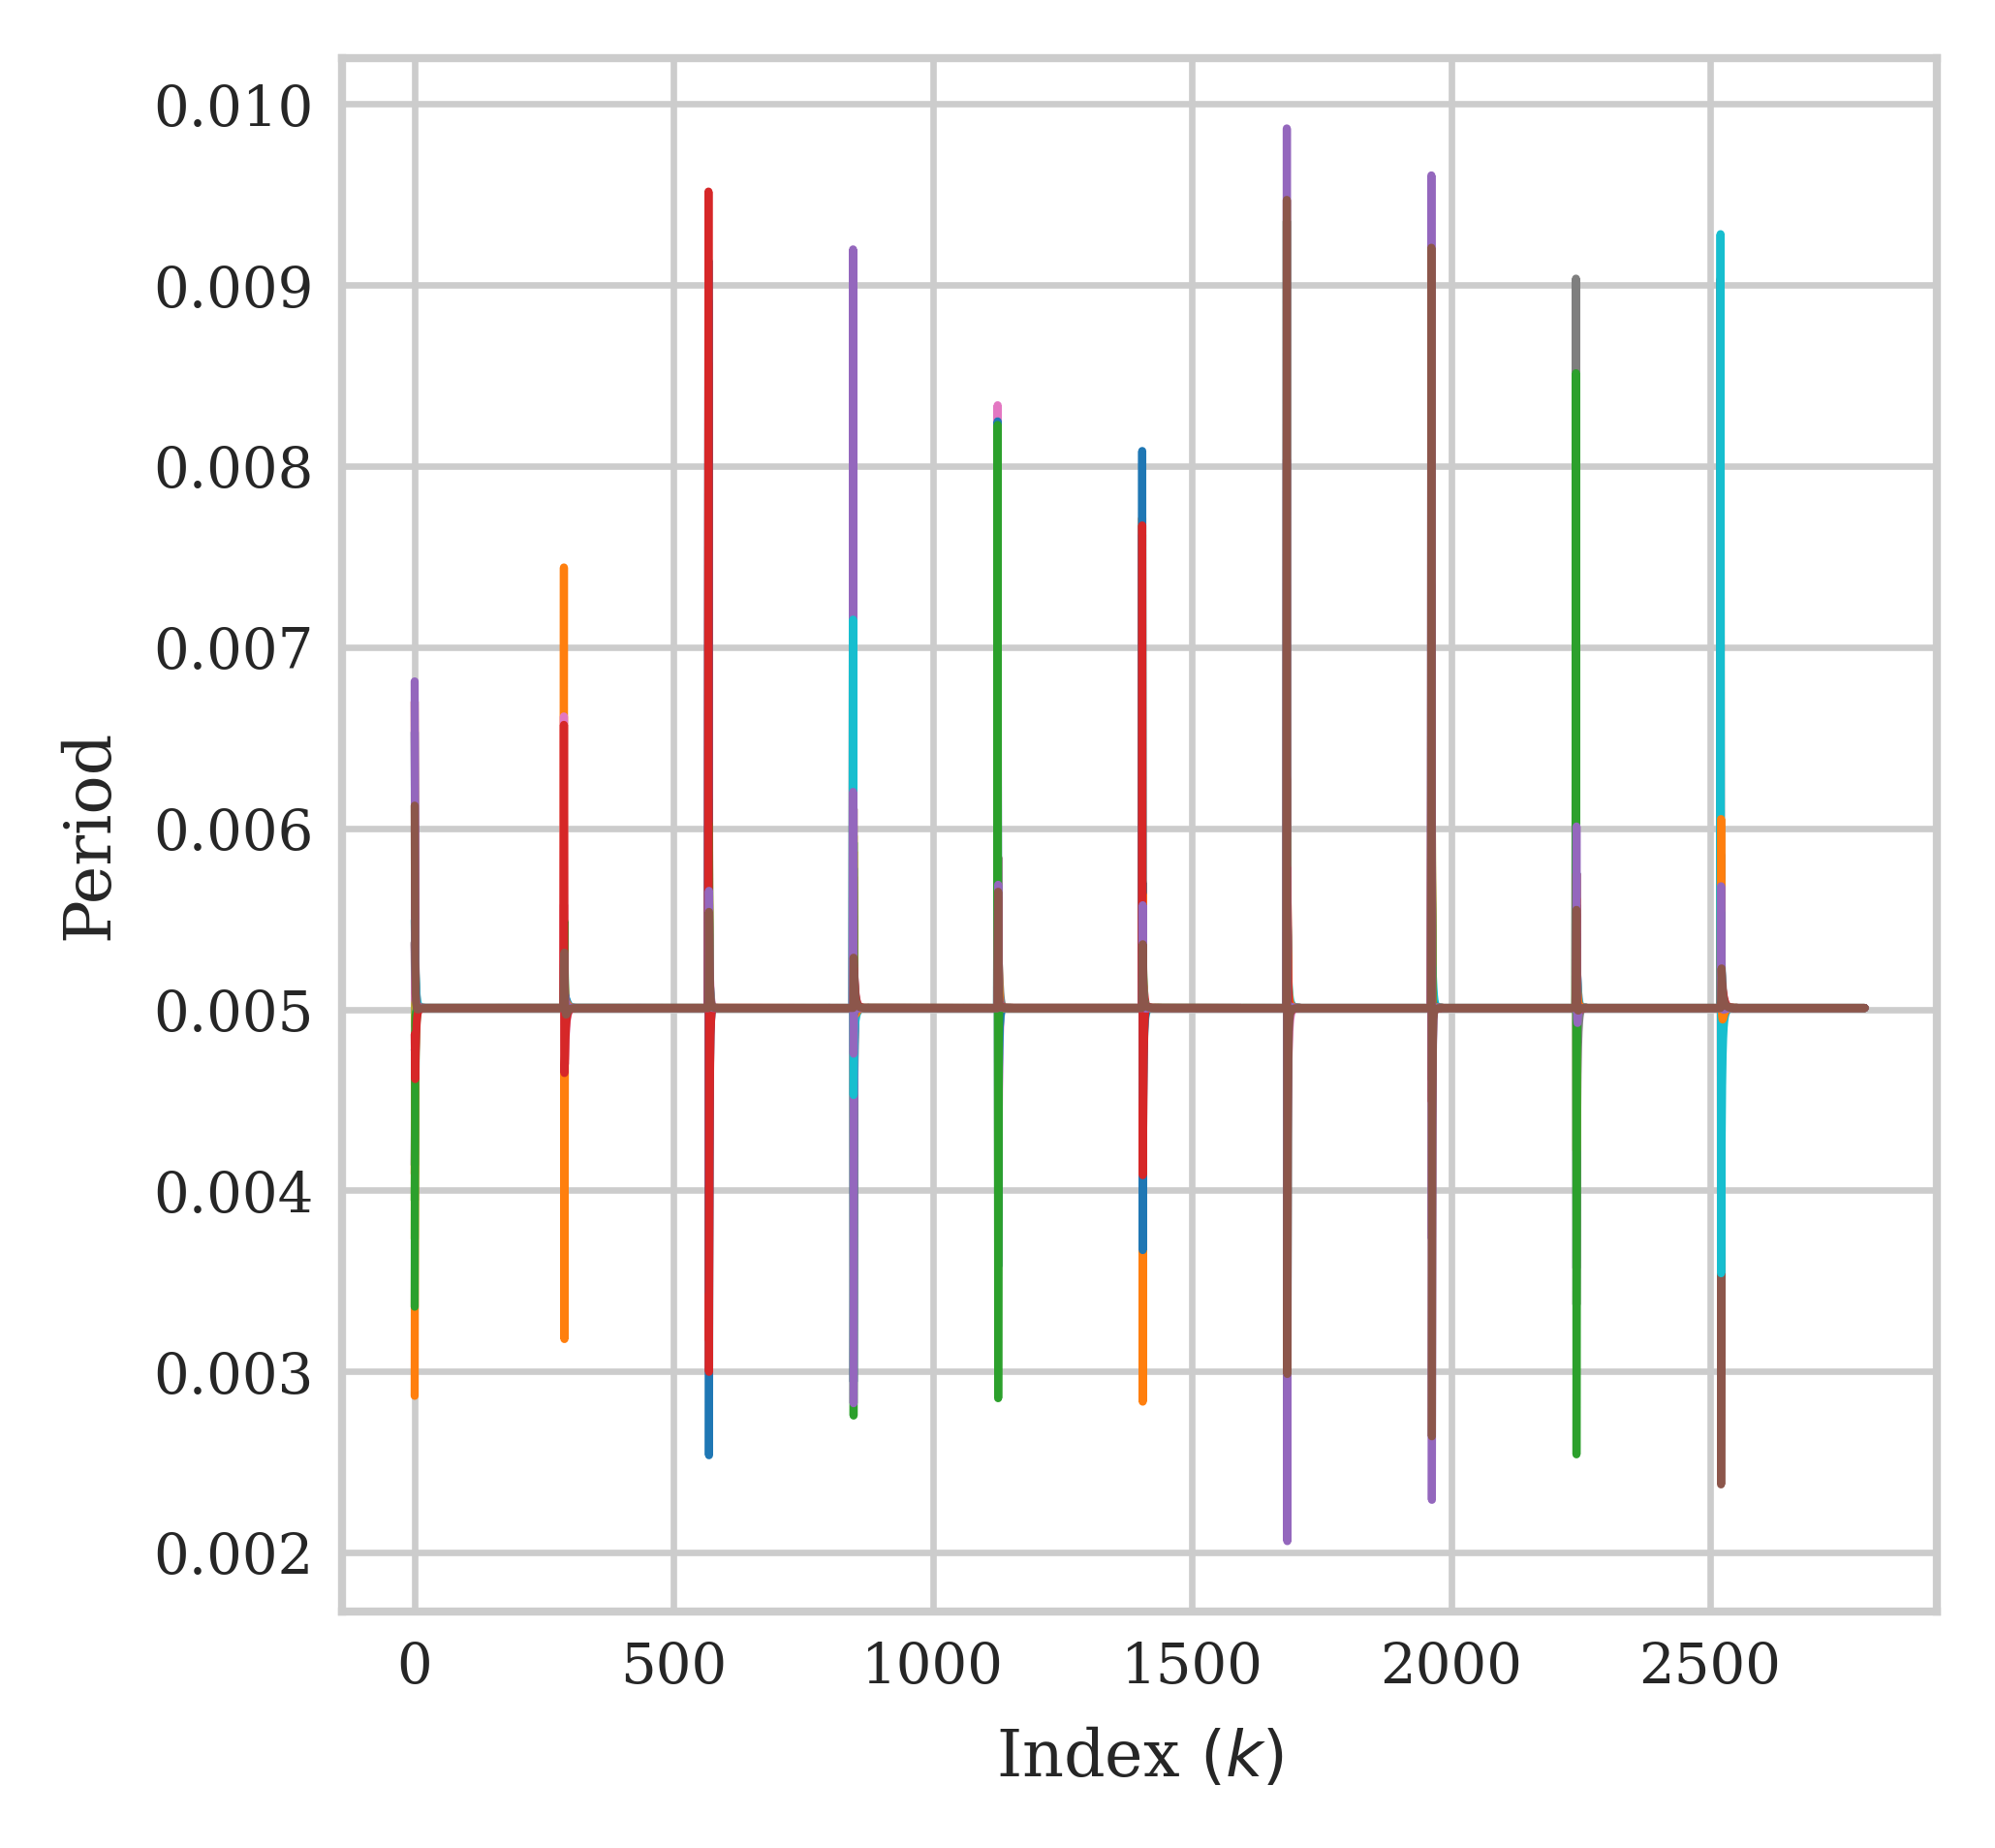

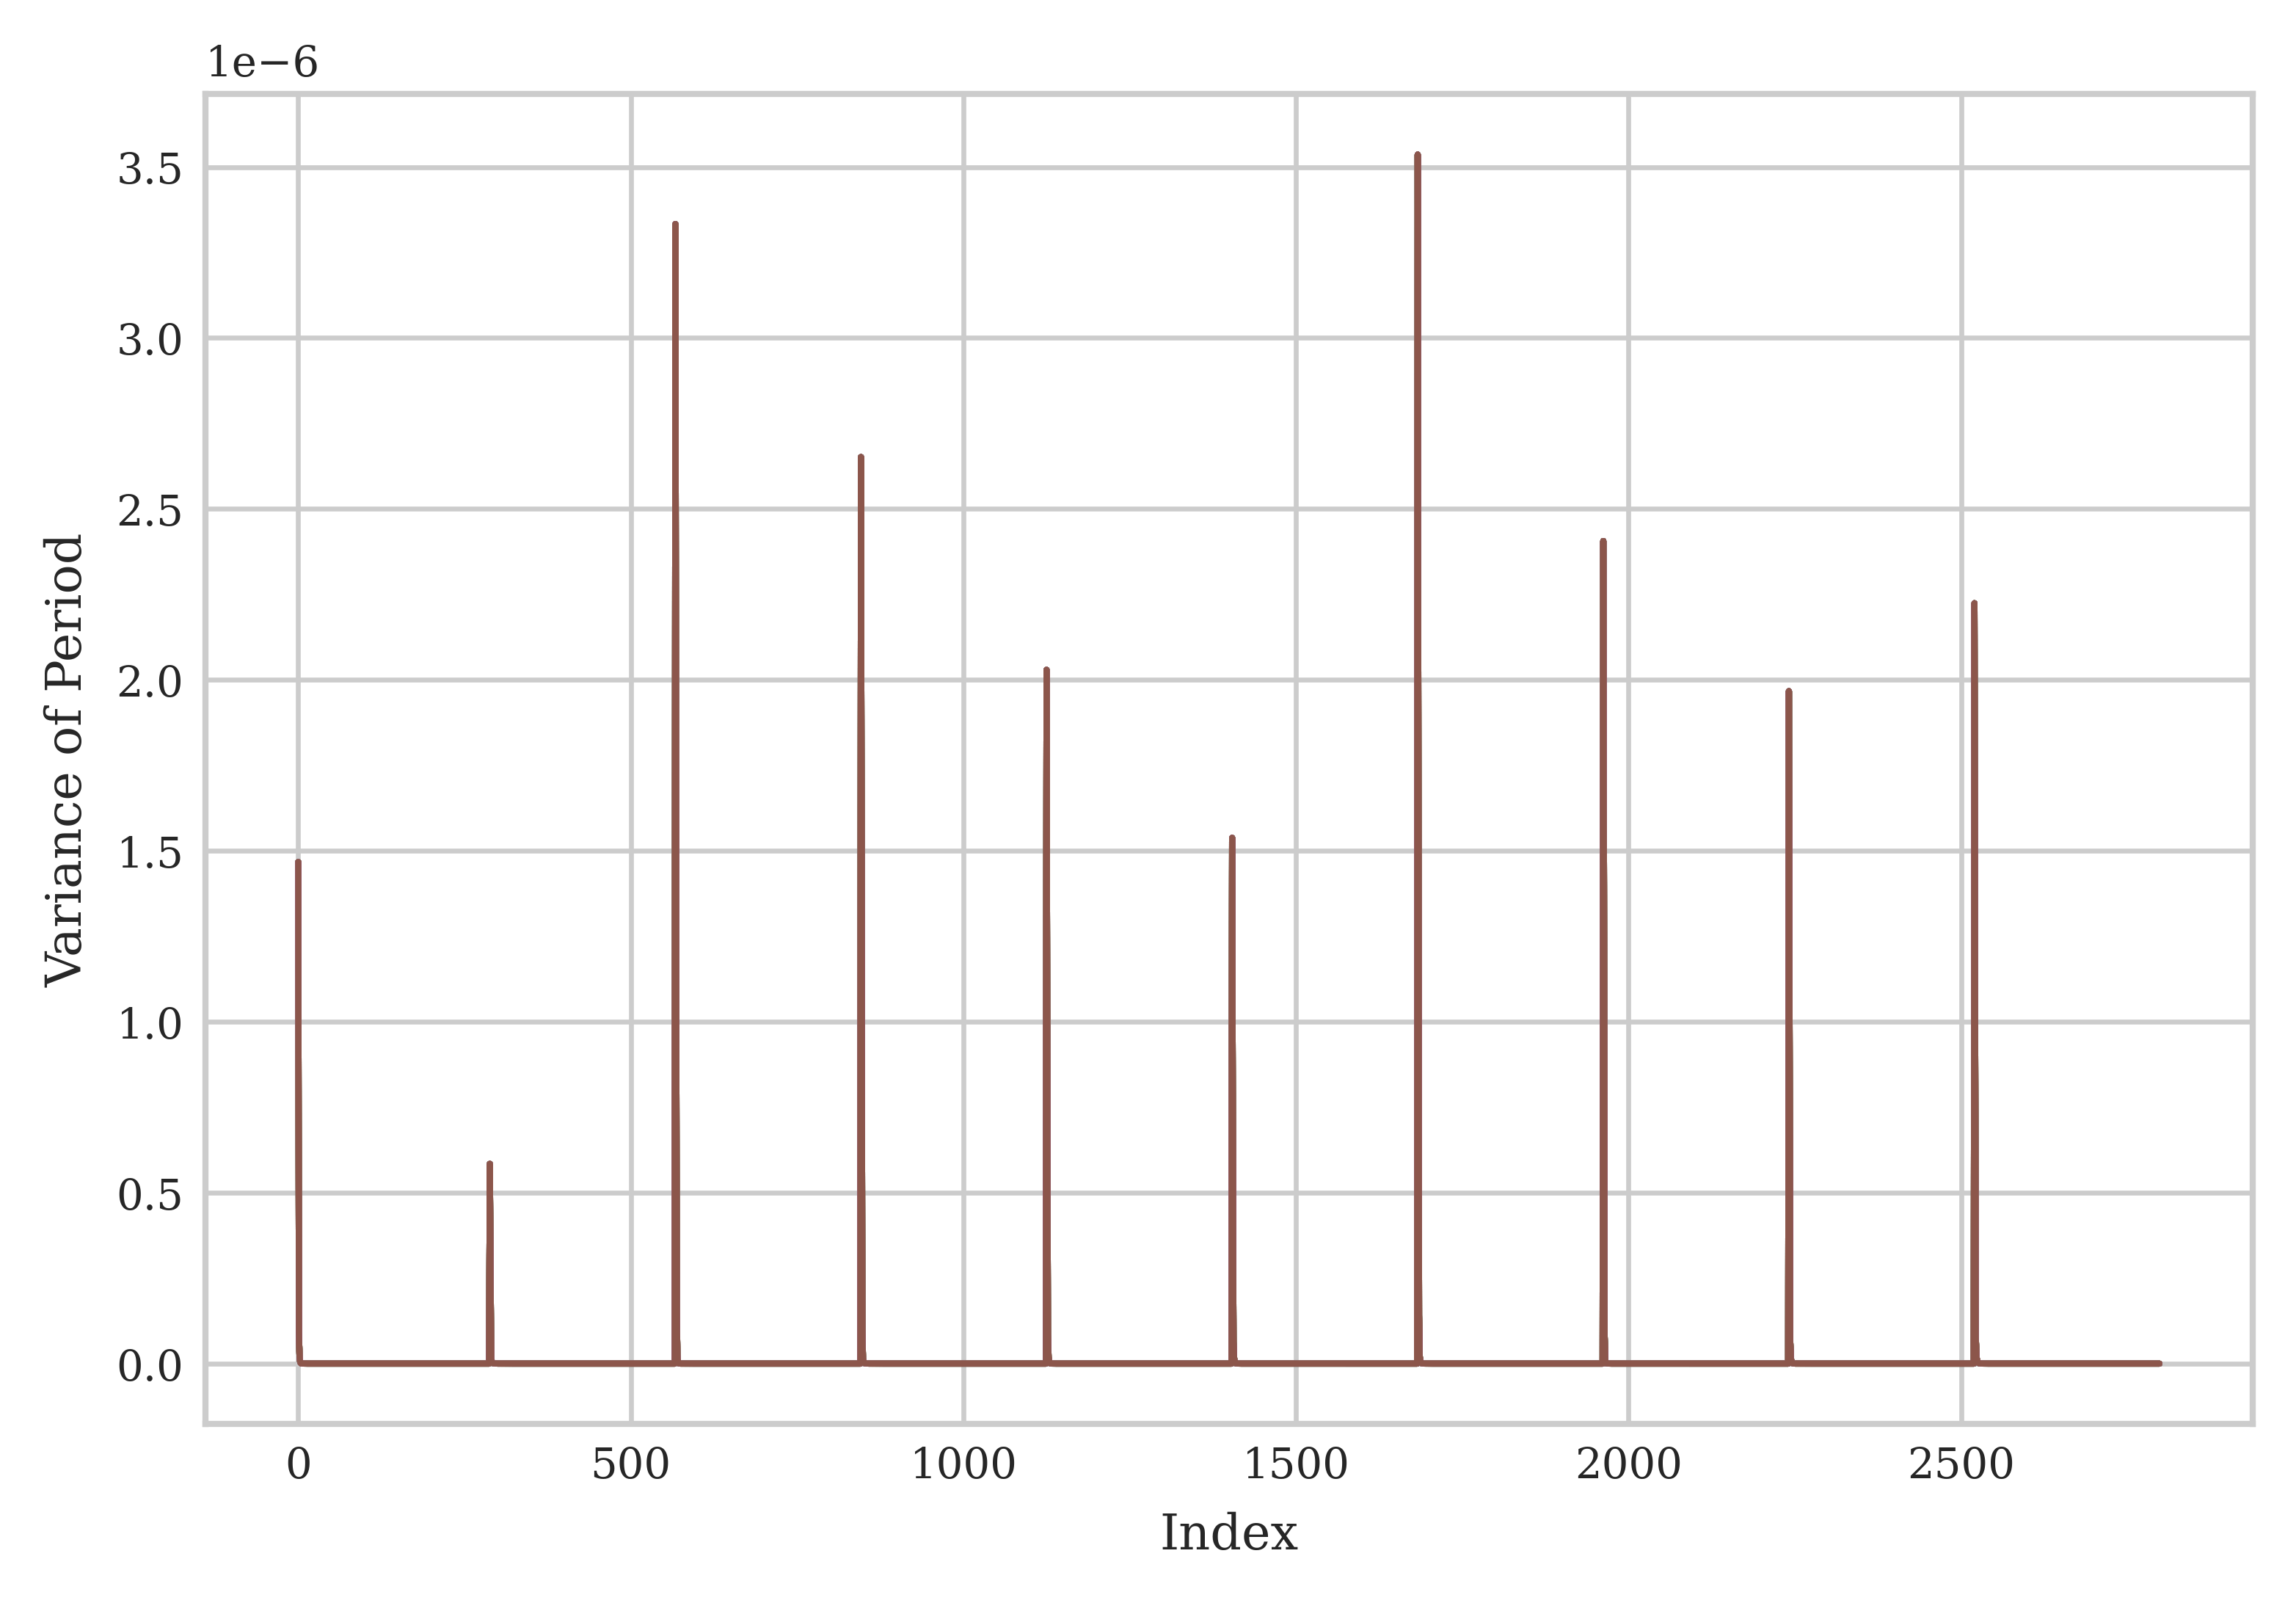

In [26]:
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
fig=plt.figure(dpi=600)
fig.set_size_inches(3.54,3.54)
period=torch.zeros(N,TT-1)
per_var=torch.zeros(TT-1)
for ind in range(TT-1):
    for i in range(N):
        period[i,ind]=torch.tensor(timenump[i,ind+1])-torch.tensor(timenump[i,ind])
    per_var[ind]=torch.var(period[:,ind])


for node in range(N):
    plt.plot(range(TT-1),(period[node,:]), linewidth=1)
plt.xlabel('Index $(k)$', fontsize=8)
plt.ylabel('Period', fontsize=8)

period is: 0.005007743835449219


Text(0, 0.5, '$\\phi_i(k)$ mod $T_{c,DNN}$')

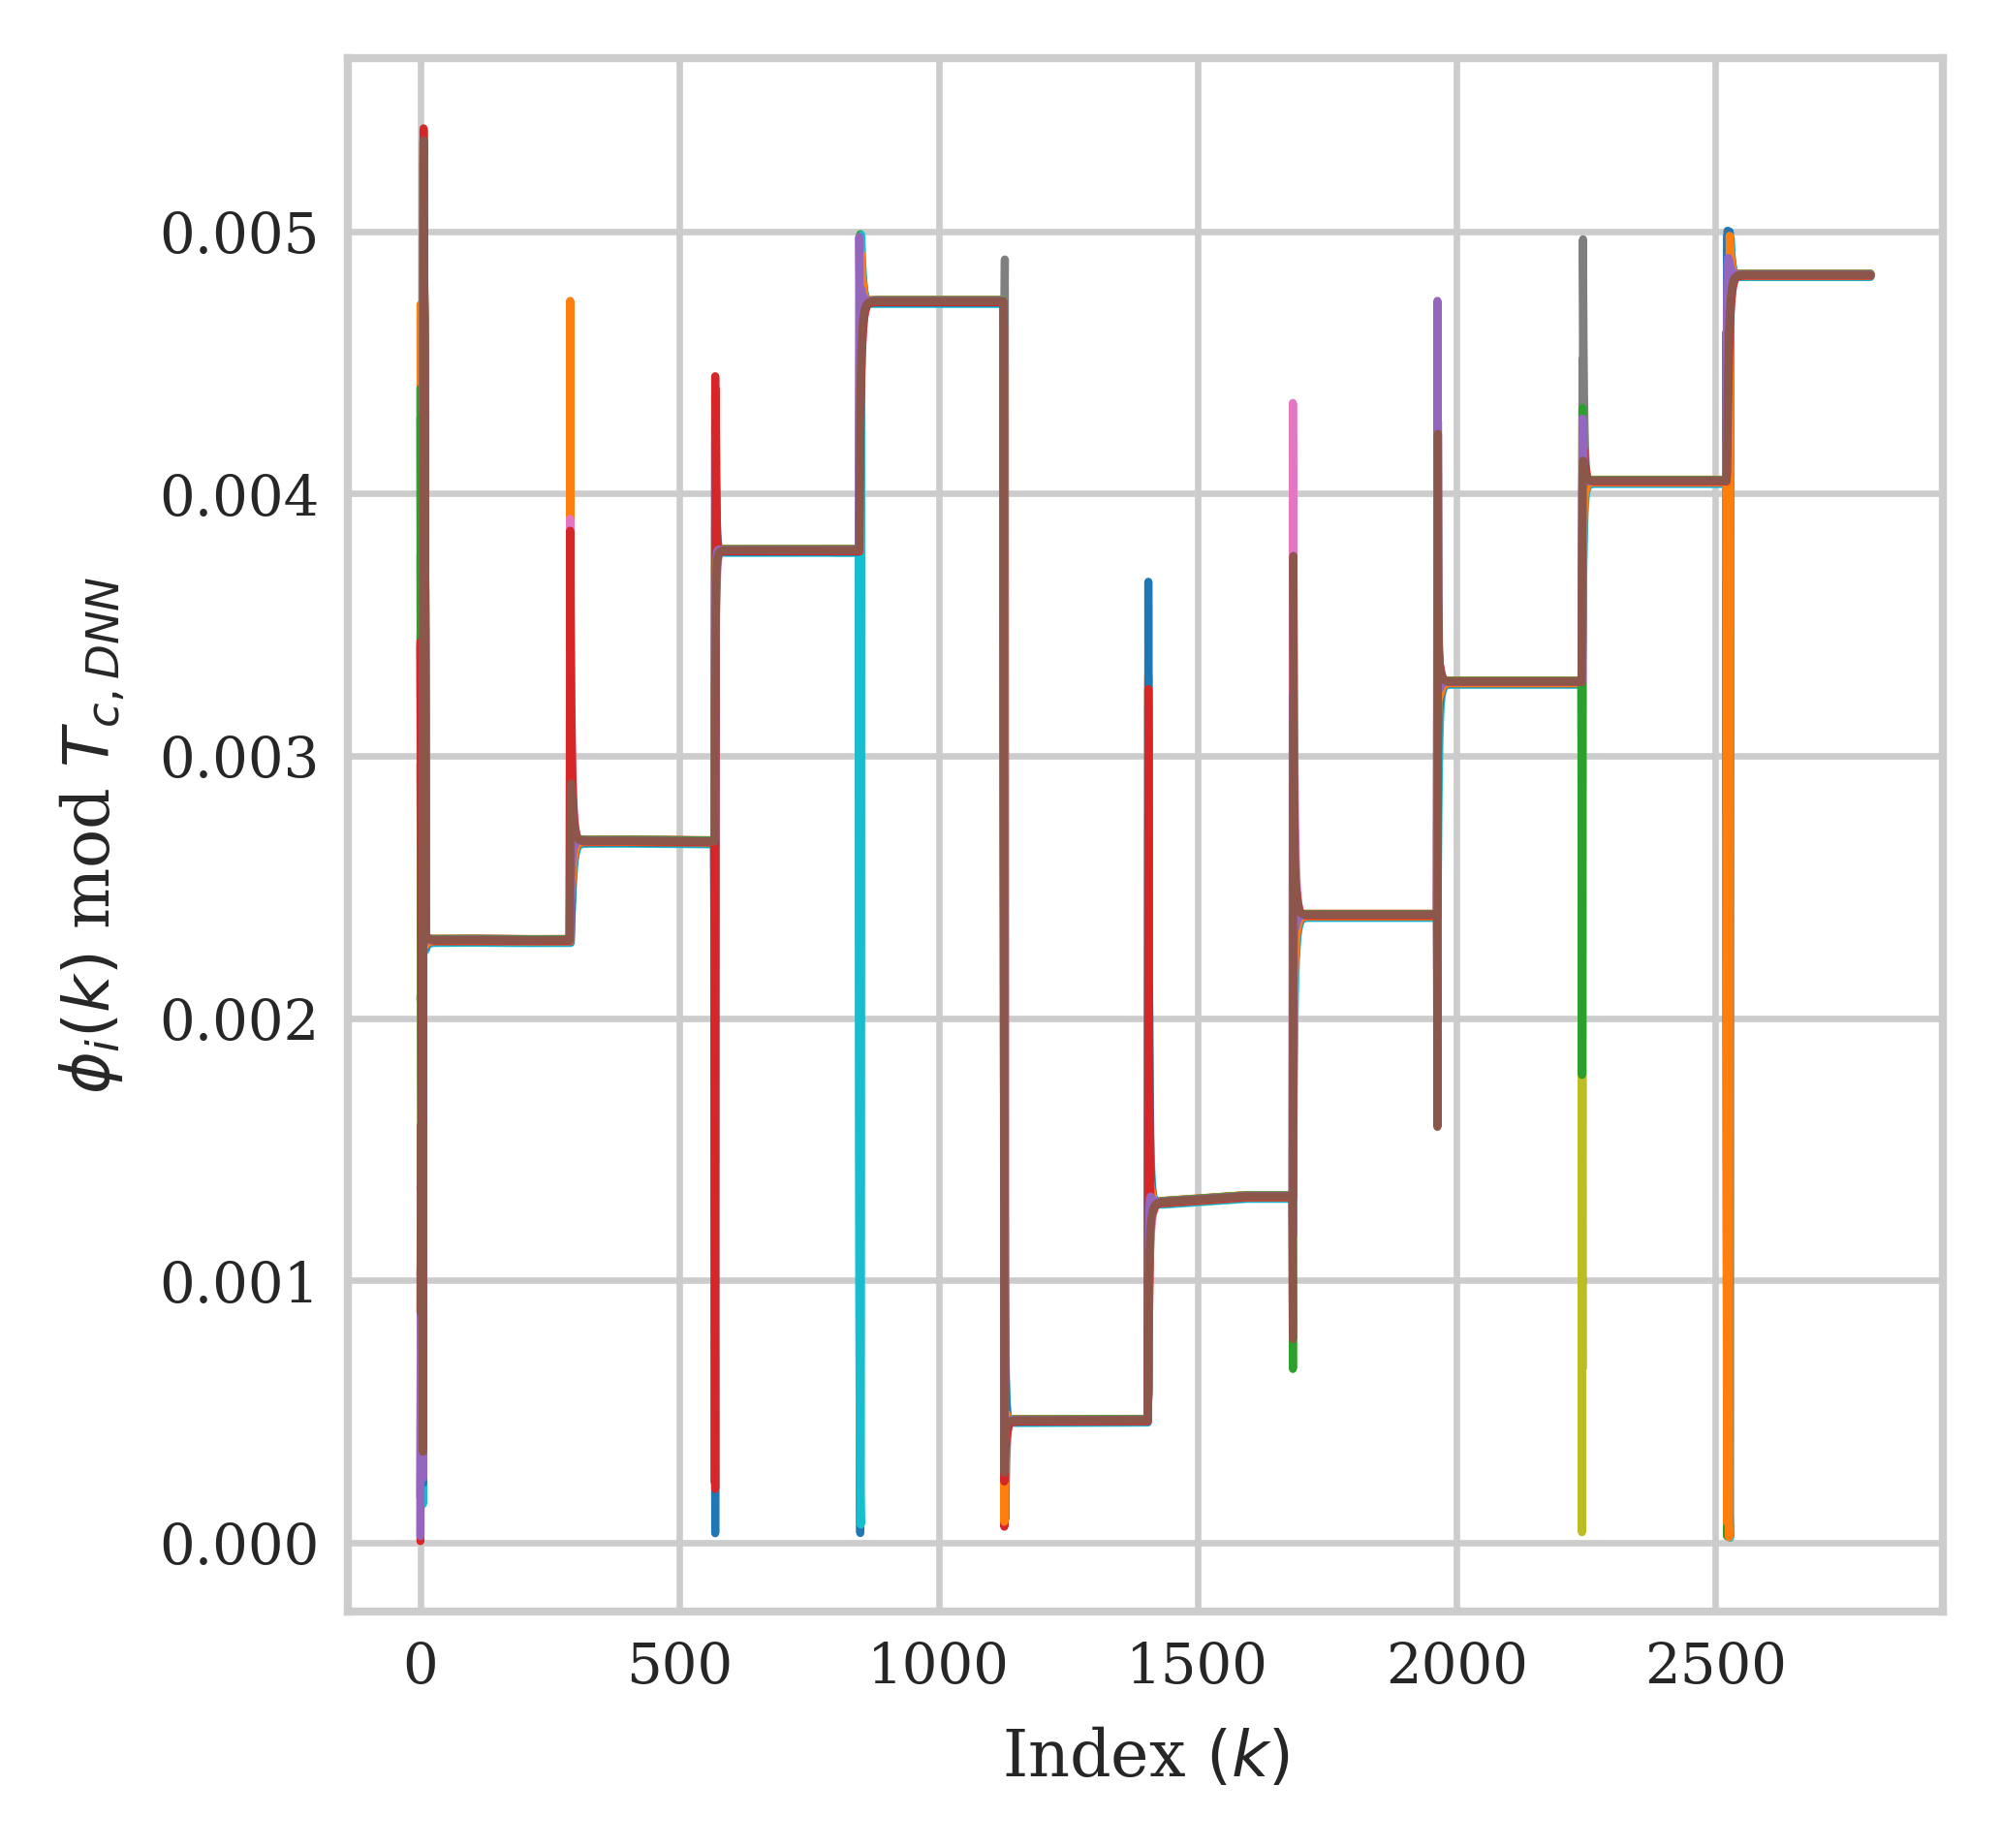

In [25]:
#MODULUS PLOTS
modulo=torch.zeros((N,TT))
per_meanMatrix=torch.zeros((1,TT-1))
for ind in range(TT-1):
    per_meanMatrix[0,ind]=torch.mean(torch.tensor(timenump[:,ind+1]-timenump[:, ind]))

for ind in range(Tbatch):
    for node in range(N):
        modulo[node,ind]=torch.tensor(timenump[node,ind])%per_meanMatrix[0,Tbatch+SncPer-1]

for Pcnt in range(Sncbatch):
    modInd=Tbatch+Pcnt*SncPer+SncPer
    refind=modInd-2
    for ind in range(Tbatch+Pcnt*SncPer,modInd):
        for node in range(N):
            modulo[node,ind]=torch.tensor(timenump[node,ind])%per_meanMatrix[0,refind]


per_mean=torch.mean(torch.tensor(timenump[:,2799]-timenump[:, 2799-1]))
print('period is:', per_mean.detach().numpy())
fig=plt.figure(dpi=600)
fig.set_size_inches(3.54,3.54)
for node in range(N):
    plt.plot(modulo[node,:], linewidth=1)
plt.xlabel('Index $(k)$', fontsize=8)
plt.ylabel('$\phi_i(k)$ mod $T_{c,DNN}$', fontsize=8)

# modulo

Maximum delay spread: 0.9723525512481112
Minimum delay spread: 0.0022852789944772427


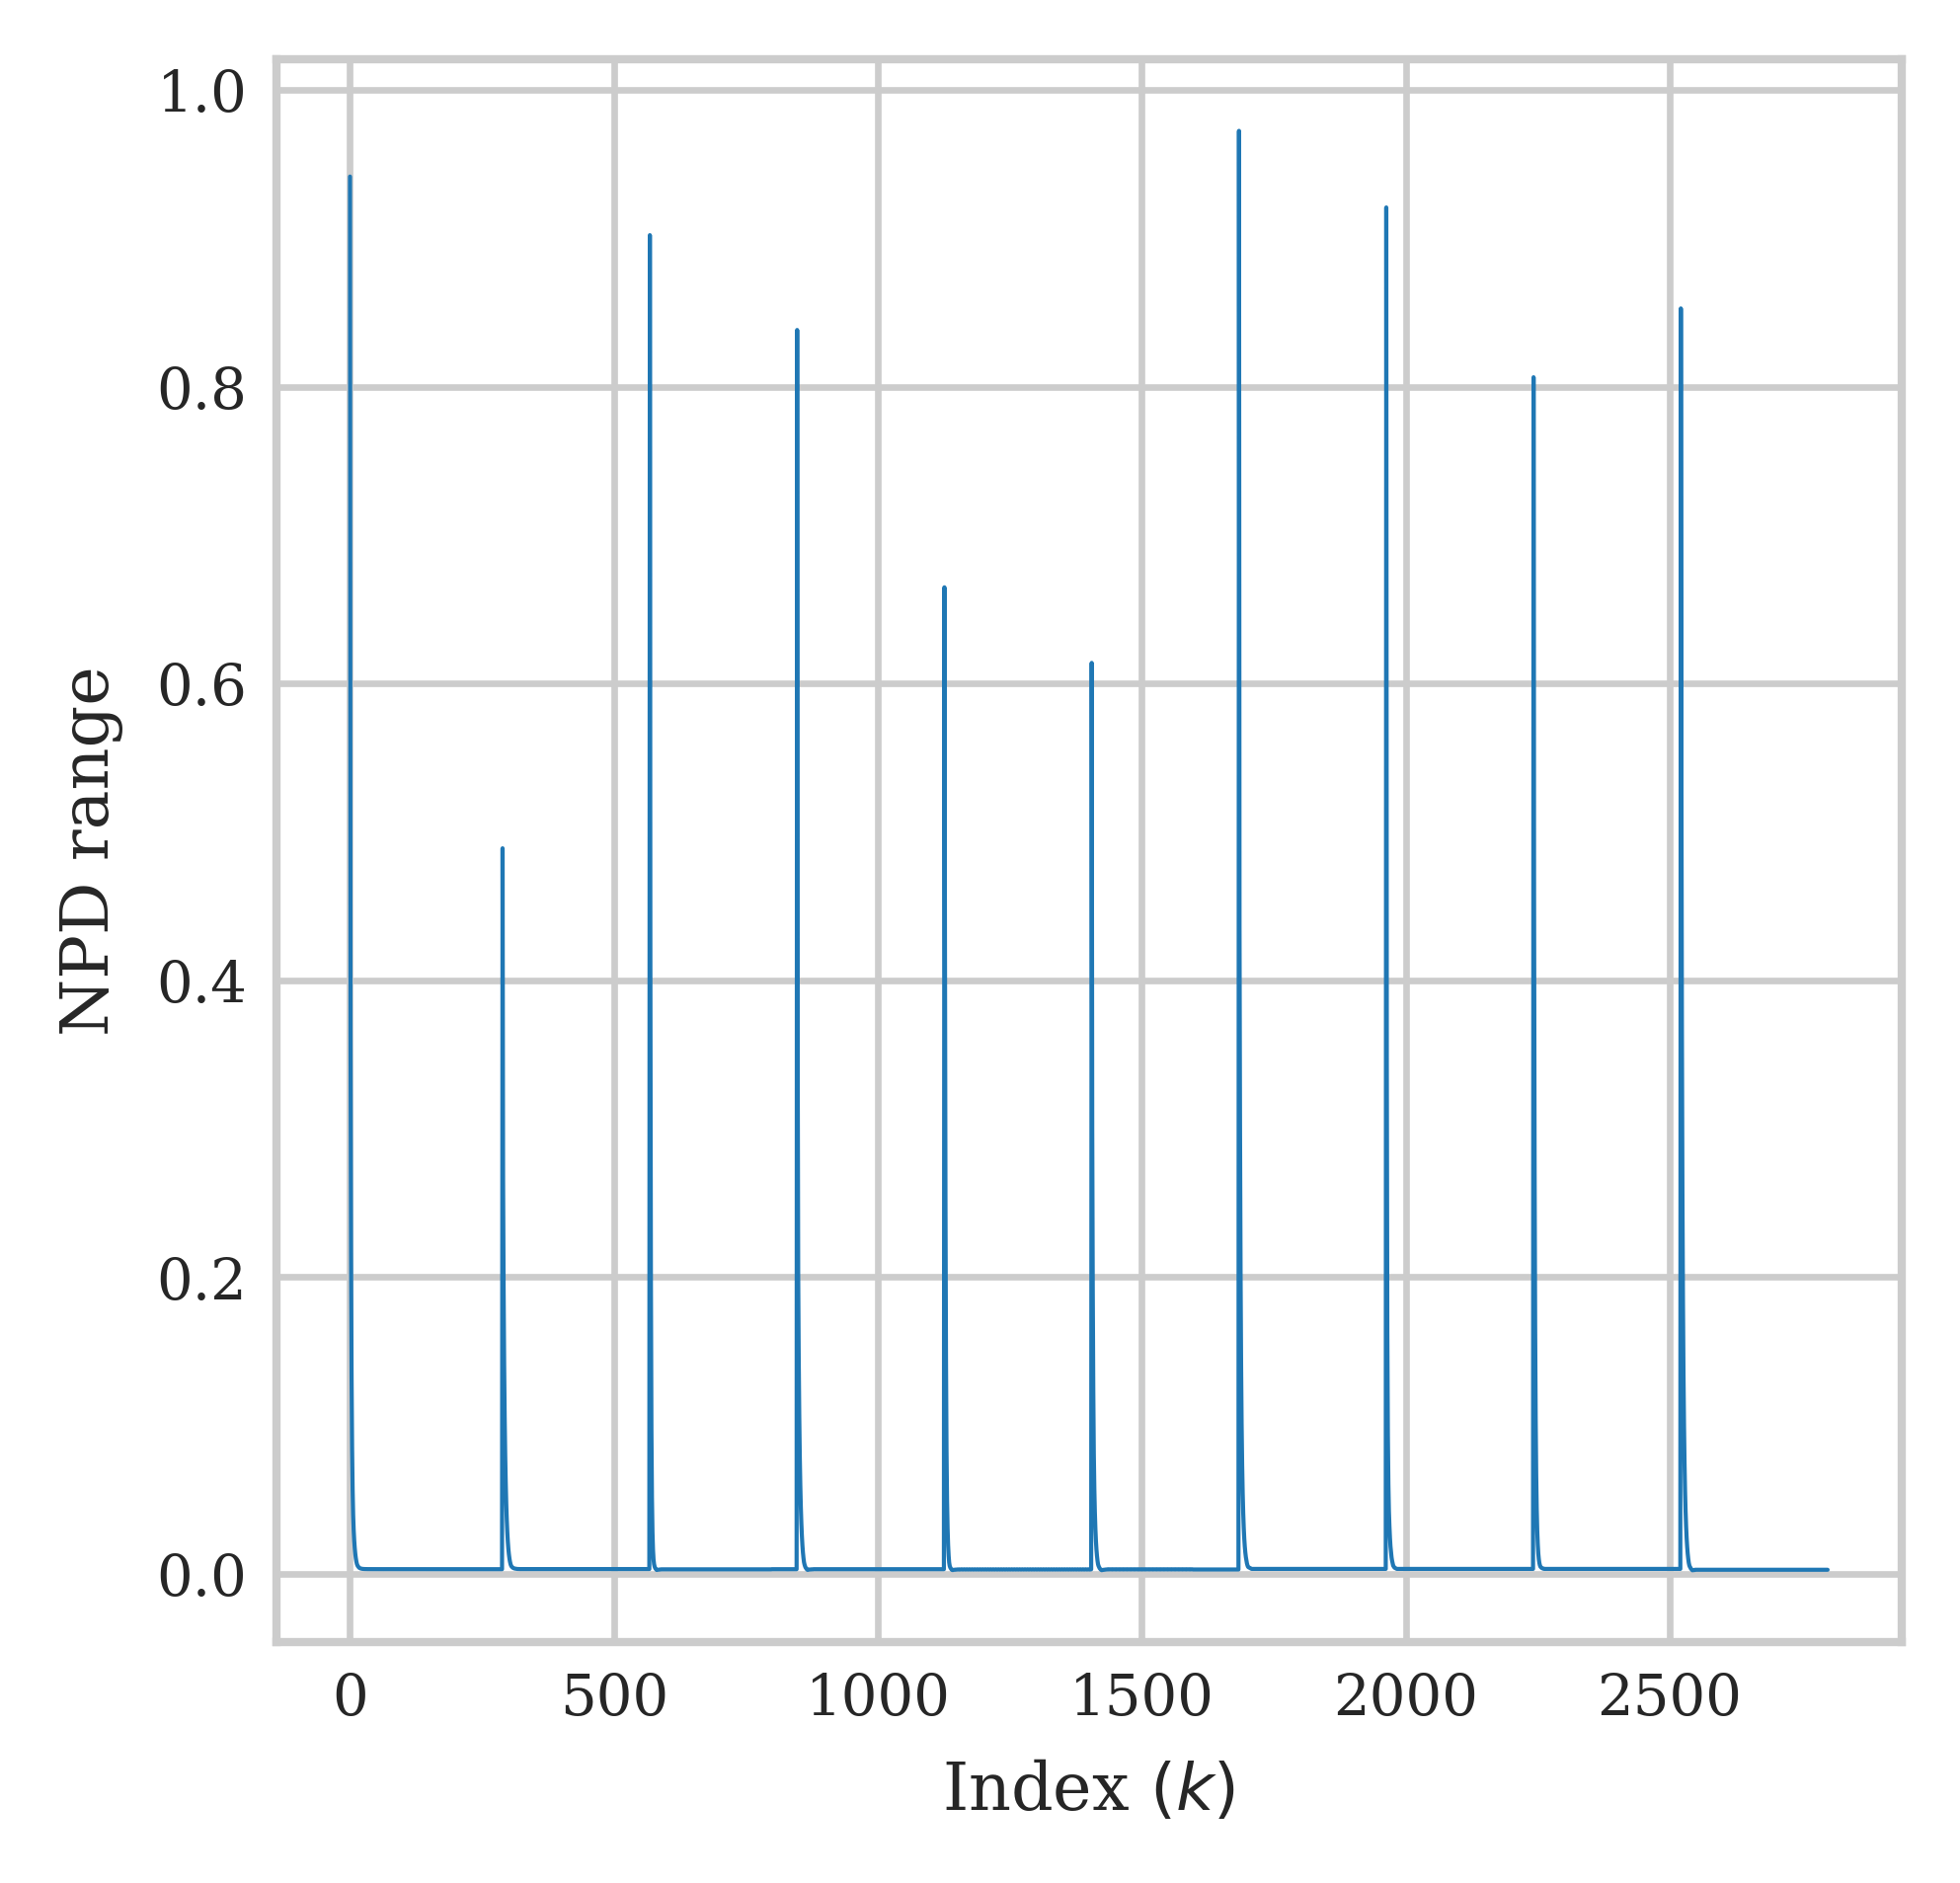

In [24]:
MAT_norm_delay=np.zeros([N,TT])
MAT_Delay_spread=np.zeros((1,TT))
for ind in range(TT):
    for node in range(N):
        MAT_norm_delay[node,ind]=(timenump[node,ind]-timenump[0,ind])/per_mean
    MAT_Delay_spread[0,ind]=np.amax(MAT_norm_delay[:,ind])-np.amin(MAT_norm_delay[:,ind])
fig=plt.figure(dpi=600)
fig.set_size_inches(3.54,3.54)
plt.plot(range(0,TT),torch.tensor(MAT_Delay_spread[0,0:TT]), linewidth=0.5)
plt.xlabel('Index $(k)$', fontsize=8)
plt.ylabel('NPD range', fontsize=8)
# plt.ylim([0.00220,0.0038])
print('Maximum delay spread:', np.amax(MAT_Delay_spread))
print('Minimum delay spread:', np.amin(MAT_Delay_spread))